In [1]:
import os
import logging
import pandas as pd
from typing import Optional
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
def read_csv_file(file_path: str) -> Optional[pd.DataFrame]:
    """
    Reads a CSV file using ";" as separator and "," as decimal separator.
    
    Parameters:
        file_path (str): Path to the CSV file.
    
    Returns:
        Optional[pd.DataFrame]: The loaded DataFrame, or None if an error occurs.
    """
    try:
        df = pd.read_csv(file_path, sep=";", decimal=",")
        return df
    except Exception as e:
        logging.error(f"Error reading file {file_path}: {e}")
        return None

def load_df(problemsize: int, earlystop: str) -> pd.DataFrame:
    """
    Loads and concatenates all CSV files from the directory structure:
        Data/ProS_{problemsize}/Es_{earlystop}
    
    Parameters:
        problemsize (int): The problem size.
        earlystop (str): The early stop flag (true, false).
    
    Returns:
        pd.DataFrame: Combined DataFrame with data from all CSV files.
    """
    base_dir = f"Data/ProS_{problemsize}/Es_{earlystop}"
    files_list = []

    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(root, file)
                files_list.append(file_path)

    logging.info(f"Found {len(files_list)} CSV files in {base_dir}")

    dataframes = []
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(read_csv_file, file_path): file_path for file_path in files_list}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files"):
            df = future.result()
            if df is not None:
                dataframes.append(df)

    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        logging.info(f"Combined DataFrame shape: {combined_df.shape}")
    else:
        logging.warning("No CSV files were successfully read. Returning an empty DataFrame.")
        combined_df = pd.DataFrame()

    return combined_df


In [2]:
import pandas as pd

def generate_tables(data):
    """
    Generate summary tables for the evolutionary algorithm performance analysis.

    Assumes 'data' is a DataFrame containing all evaluations with at least the following columns:
      - Evaluations, BestFitness, MeanFitness, Diversity, UniqueIndividuals,
        PopulationSize, ProblemSize, BitFlipProbability, CrossoverProbability, RandomSeed.

    The function extracts the final record of each run (i.e., the row with the maximum Evaluations per group)
    and produces:
      - fitness_summary: Summary of the final BestFitness.
      - diversity_summary: Summary of the final Diversity.
      - evaluations_summary: Summary of the Evaluations used.

    It prints each summary and returns a dictionary with the three tables.
    """
    final_records = data.sort_values('Evaluations', ascending=False) \
        .drop_duplicates(subset=['BitFlipProbability', 'CrossoverProbability', 'RandomSeed']) \
        .reset_index(drop=True)



    fitness_summary = final_records.groupby(['BitFlipProbability', 'CrossoverProbability']).agg(
        MeanFinalFitness=('MeanFitness', 'mean'),
        StdFinalFitness=('MeanFitness', 'std'),
        MaxFinalFitness=('MeanFitness', 'max'),
        MinFinalFitness=('MeanFitness', 'min')
    ).reset_index()

    diversity_summary = final_records.groupby(['BitFlipProbability', 'CrossoverProbability']).agg(
        MeanFinalDiversity=('Diversity', 'mean'),
        StdFinalDiversity=('Diversity', 'std'),
        MaxFinalDiversity=('Diversity', 'max'),
        MinFinalDiversity=('Diversity', 'min')
    ).reset_index()

    evaluations_summary = final_records.groupby(['BitFlipProbability', 'CrossoverProbability']).agg(
        MeanEvaluations=('Evaluations', 'mean'),
        StdEvaluations=('Evaluations', 'std'),
        MinEvaluations=('Evaluations', 'min'),
        MaxEvaluations=('Evaluations', 'max')
    ).reset_index()

    print("Fitness Summary:")
    display(fitness_summary)
    print("\nDiversity Summary:")
    display(diversity_summary)
    print("\nEvaluations Summary:")
    display(evaluations_summary)

    return {
        "fitness_summary": fitness_summary,
        "diversity_summary": diversity_summary,
        "evaluations_summary": evaluations_summary
    }


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def generate_plots(data):
    """
    Generates a comprehensive set of plots for analyzing the performance of the evolutionary algorithm.
    
    Assumes 'data' is a DataFrame with all evaluations and contains at least the following columns:
      - Evaluations, BestFitness, MeanFitness, Diversity, UniqueIndividuals,
        PopulationSize, ProblemSize, BitFlipProbability, CrossoverProbability, RandomSeed.
      
    The following plots are generated:
      1. Heatmap: Mean final BestFitness (grouped by BitFlipProbability and CrossoverProbability).
      2. Heatmap: Mean final Diversity (grouped by BitFlipProbability and CrossoverProbability).
      3. Scatter Plot: BestFitness vs. Diversity (final records) distinguishing both probabilities.
      4. Line Plot: Evolution of MeanFitness over Evaluations, distinguishing BitFlipProbability (hue)
         and CrossoverProbability (style).
      5. Line Plot: Evolution of Diversity over Evaluations, distinguishing BitFlipProbability (hue)
         and CrossoverProbability (style).
      6. Violin Plot + Swarm Plot: Final distribution of BestFitness by parameter combination.
      7. Violin Plot + Swarm Plot: Final distribution of Diversity by parameter combination.
      8. Boxplot: Final distribution of BestFitness by BitFlipProbability and CrossoverProbability.
      9. Heatmap: Correlation between final metrics.
      10. Line Plot: Delta BestFitness over Evaluations.
    """
    # 1) Extract final records (row with max Evaluations per group)
    group_cols = ['BitFlipProbability', 'CrossoverProbability', 'RandomSeed']
    idx = data.groupby(group_cols)['Evaluations'].idxmax().dropna()
    final_records = data.loc[data.groupby(group_cols)['Evaluations'].idxmax()].reset_index(drop=True)

    # 2) Heatmap: Mean final BestFitness
    fitness_summary = final_records.groupby(['BitFlipProbability', 'CrossoverProbability']).agg(
        MeanFinalFitness=('BestFitness', 'mean')
    ).reset_index()
    pivot_fitness = fitness_summary.pivot(index="BitFlipProbability",
                                          columns="CrossoverProbability",
                                          values="MeanFinalFitness")
    if pivot_fitness.empty:
        print("Warning: pivot_fitness is empty. The MeanFitness heatmap will not be generated.")
    else:
        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot_fitness, annot=True, fmt=".2f", cmap="magma")
        plt.title("Heatmap: Mean Final MeanFitness")
        plt.xlabel("Crossover Probability")
        plt.ylabel("BitFlip Probability")
        plt.show()

    # 3) Heatmap: Mean final Diversity
    diversity_summary = final_records.groupby(['BitFlipProbability', 'CrossoverProbability']).agg(
        MeanFinalDiversity=('Diversity', 'mean')
    ).reset_index()
    pivot_diversity = diversity_summary.pivot(index="BitFlipProbability",
                                              columns="CrossoverProbability",
                                              values="MeanFinalDiversity")
    if pivot_diversity.empty:
        print("Warning: pivot_diversity is empty. The Diversity heatmap will not be generated.")
    else:
        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot_diversity, annot=True, fmt=".2f", cmap="inferno")
        plt.title("Heatmap: Mean Final Diversity")
        plt.xlabel("Crossover Probability")
        plt.ylabel("BitFlip Probability")
        plt.show()

    # 4) Scatter Plot: MeanFitness vs. Diversity (final records)
    if not final_records.empty:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=final_records,
            x="MeanFitness",
            y="Diversity",
            hue="BitFlipProbability",
            style="CrossoverProbability",
            palette="Set1",
            s=100
        )
        plt.title("Scatter: MeanFitness vs. Diversity (Final)")
        plt.xlabel("MeanFitness")
        plt.ylabel("Diversity")
        plt.show()
    else:
        print("Warning: No final records for the Scatter Plot.")

    # 5) Line Plot: Evolution of MeanFitness over Evaluations
    if not data.empty:
        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=data,
            x="Evaluations",
            y="MeanFitness",
            hue="BitFlipProbability",
            style="CrossoverProbability",
            estimator='mean',
            errorbar='sd',
            palette="tab10"
        )
        plt.title("Evolution of MeanFitness over Evaluations")
        plt.xlabel("Evaluations")
        plt.ylabel("MeanFitness")
        max_val = data["MeanFitness"].max()
        plt.ylim(max_val * 0.75, max_val)
        plt.legend(title="BitFlipProbability / CrossoverProbability")
        plt.show()
    else:
        print("Warning: The DataFrame is empty. MeanFitness evolution plot will not be generated.")

    # 6) Line Plot: Evolution of Diversity over Evaluations
    if not data.empty:
        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=data,
            x="Evaluations",
            y="Diversity",
            hue="BitFlipProbability",
            style="CrossoverProbability",
            estimator='mean',
            errorbar='sd',
            palette="tab10"
        )
        plt.title("Evolution of Diversity over Evaluations")
        plt.xlabel("Evaluations")
        plt.ylabel("Diversity")
        plt.legend(title="BitFlipProbability / CrossoverProbability")
        plt.show()
    else:
        print("Warning: The DataFrame is empty. Diversity evolution plot will not be generated.")

    # 7) Violin Plot + Swarm Plot: Final distribution of MeanFitness by parameter combination
    if not final_records.empty:
        final_records = final_records.copy()
        final_records["Params"] = final_records.apply(
            lambda row: f"BFP={row['BitFlipProbability']:.2f}, CP={row['CrossoverProbability']:.2f}",
            axis=1
        )
        unique_params = final_records.sort_values(["BitFlipProbability", "CrossoverProbability"])["Params"].unique()

        plt.figure(figsize=(14, 6))
        sns.violinplot(
            data=final_records,
            x="Params",
            y="MeanFitness",
            order=unique_params,
            cut=0,
            palette="Pastel1",
            bw_method=0.2
        )
        sns.swarmplot(
            data=final_records,
            x="Params",
            y="MeanFitness",
            order=unique_params,
            color="k",
            alpha=0.6,
            size=0.01
        )
        plt.title("Violin Plot: Final Distribution of MeanFitness")
        plt.xlabel("Parameter Combination (BFP, CP)")
        plt.ylabel("MeanFitness (Final)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # 8) Violin Plot + Swarm Plot: Final distribution of Diversity by parameter combination
        plt.figure(figsize=(14, 6))
        sns.violinplot(
            data=final_records,
            x="Params",
            y="Diversity",
            order=unique_params,
            cut=0,
            palette="Pastel2",
            bw_method=0.4
        )
        sns.swarmplot(
            data=final_records,
            x="Params",
            y="Diversity",
            order=unique_params,
            color="k",
            alpha=0.6,
            size=0.01
        )
        plt.title("Violin Plot: Final Distribution of Diversity")
        plt.xlabel("Parameter Combination (BFP, CP)")
        plt.ylabel("Diversity (Final)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # 9) Boxplot: Final distribution of MeanFitness by BitFlipProbability and CrossoverProbability
        plt.figure(figsize=(10, 6))
        sns.boxplot(
            data=final_records,
            x="BitFlipProbability",
            y="MeanFitness",
            hue="CrossoverProbability",
            palette="Paired"
        )
        plt.title("Boxplot: Final MeanFitness by BitFlipProbability and CrossoverProbability")
        plt.xlabel("BitFlipProbability")
        plt.ylabel("MeanFitness (Final)")
        plt.legend(title="CrossoverProbability")
        plt.show()

        # 10) Heatmap: Correlation between final metrics
        agg_data = final_records[['BestFitness', 'MeanFitness', 'Diversity', 'Evaluations']].copy()
        plt.figure(figsize=(8, 6))
        sns.heatmap(agg_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Heatmap: Correlation Between Final Metrics")
        plt.show()

    else:
        print("Warning: There are no final records for the final distribution plots.")

2025-02-16 23:30:02,136 - INFO - Found 2970 CSV files in Data/ProS_25/Es_false
Processing files: 100%|██████████| 2970/2970 [00:08<00:00, 340.77it/s]
2025-02-16 23:30:11,913 - INFO - Combined DataFrame shape: (59310900, 10)


Evaluations  BestFitness  MeanFitness  Diversity  UniqueIndividuals  \
0                  31           19      13.0333    12.5770                 30   
1                  32           19      13.2667    12.5517                 30   
2                  33           19      13.5000    12.4529                 30   
3                  34           19      13.6667    12.3862                 30   
4                  35           19      13.7333    12.3494                 29   
...               ...          ...          ...        ...                ...   
59300895         9996           24      22.6333     4.3011                 30   
59300896         9997           24      22.6333     4.3011                 30   
59300897         9998           24      22.6333     4.3011                 30   
59300898         9999           24      22.6333     4.3011                 30   
59300899        10000           24      22.6333     4.3011                 30   

          PopulationSize  ProblemSize  BitFlipProbability  \
0                     30           25                0.05   
1                     30           25                0.05   
2                     30           25                0.05   
3                     30           25                0.05   
4                     30           25                0.05   
...                  ...          ...                 ...   
59300895              30           25                0.30   
59300896              30           25                0.30   
59300897              30           25                0.30   
59300898              30           25                0.30   
59300899              30           25                0.30   

          CrossoverProbability  RandomSeed  
0                          0.0          22  
1                          0.0          22  
2                          0.0          22  
3                          0.0          22  
4                          0.0          22  
...                        ...         ...  
59300895                   1.0          97  
59300896                   1.0          97  
59300897                   1.0          97  
59300898                   1.0          97  
59300899                   1.0          97  

[29610900 rows x 10 columns]

Fitness Summary:


BitFlipProbability  CrossoverProbability  MeanFinalFitness  \
0                 0.05                  0.00         25.000000   
1                 0.05                  0.25         25.000000   
2                 0.05                  0.50         25.000000   
3                 0.05                  0.75         25.000000   
4                 0.05                  1.00         25.000000   
5                 0.10                  0.00         25.000000   
6                 0.10                  0.25         25.000000   
7                 0.10                  0.50         25.000000   
8                 0.10                  0.75         25.000000   
9                 0.10                  1.00         25.000000   
10                0.15                  0.00         25.000000   
11                0.15                  0.25         25.000000   
12                0.15                  0.50         25.000000   
13                0.15                  0.75         25.000000   
14                0.15                  1.00         25.000000   
15                0.20                  0.00         24.471717   
16                0.20                  0.25         24.495622   
17                0.20                  0.50         24.554205   
18                0.20                  0.75         24.593606   
19                0.20                  1.00         24.611444   
20                0.25                  0.00         23.566329   
21                0.25                  0.25         23.613802   
22                0.25                  0.50         23.685186   
23                0.25                  0.75         23.713469   
24                0.25                  1.00         23.748146   
25                0.30                  0.00         22.680133   
26                0.30                  0.25         22.781142   
27                0.30                  0.50         22.785515   
28                0.30                  0.75         22.777438   
29                0.30                  1.00         22.844443   

    StdFinalFitness  MaxFinalFitness  MinFinalFitness  
0          0.000000          25.0000          25.0000  
1          0.000000          25.0000          25.0000  
2          0.000000          25.0000          25.0000  
3          0.000000          25.0000          25.0000  
4          0.000000          25.0000          25.0000  
5          0.000000          25.0000          25.0000  
6          0.000000          25.0000          25.0000  
7          0.000000          25.0000          25.0000  
8          0.000000          25.0000          25.0000  
9          0.000000          25.0000          25.0000  
10         0.000000          25.0000          25.0000  
11         0.000000          25.0000          25.0000  
12         0.000000          25.0000          25.0000  
13         0.000000          25.0000          25.0000  
14         0.000000          25.0000          25.0000  
15         0.203836          24.9667          24.0000  
16         0.204685          25.0000          24.1000  
17         0.231214          25.0000          24.1333  
18         0.225910          25.0000          24.1667  
19         0.224171          25.0000          24.1333  
20         0.247043          24.2000          23.1333  
21         0.238953          24.2000          23.1333  
22         0.203498          24.2000          23.2667  
23         0.233184          24.3000          23.2667  
24         0.259741          24.1667          23.2333  
25         0.265597          23.3333          22.1333  
26         0.234313          23.3000          22.2333  
27         0.242911          23.4000          22.2667  
28         0.252689          23.4000          22.2333  
29         0.259249          23.3000          22.2000


Diversity Summary:


BitFlipProbability  CrossoverProbability  MeanFinalDiversity  \
0                 0.05                  0.00            0.000000   
1                 0.05                  0.25            0.000000   
2                 0.05                  0.50            0.000000   
3                 0.05                  0.75            0.000000   
4                 0.05                  1.00            0.000000   
5                 0.10                  0.00            0.000000   
6                 0.10                  0.25            0.000000   
7                 0.10                  0.50            0.000000   
8                 0.10                  0.75            0.000000   
9                 0.10                  1.00            0.000000   
10                0.15                  0.00            0.000000   
11                0.15                  0.25            0.000000   
12                0.15                  0.50            0.000000   
13                0.15                  0.75            0.000000   
14                0.15                  1.00            0.000000   
15                0.20                  0.00            1.009565   
16                0.20                  0.25            0.962074   
17                0.20                  0.50            0.859490   
18                0.20                  0.75            0.783441   
19                0.20                  1.00            0.752626   
20                0.25                  0.00            2.641074   
21                0.25                  0.25            2.575244   
22                0.25                  0.50            2.444000   
23                0.25                  0.75            2.397837   
24                0.25                  1.00            2.353184   
25                0.30                  0.00            4.138441   
26                0.30                  0.25            3.988853   
27                0.30                  0.50            3.963194   
28                0.30                  0.75            3.987486   
29                0.30                  1.00            3.884961   

    StdFinalDiversity  MaxFinalDiversity  MinFinalDiversity  
0            0.000000             0.0000             0.0000  
1            0.000000             0.0000             0.0000  
2            0.000000             0.0000             0.0000  
3            0.000000             0.0000             0.0000  
4            0.000000             0.0000             0.0000  
5            0.000000             0.0000             0.0000  
6            0.000000             0.0000             0.0000  
7            0.000000             0.0000             0.0000  
8            0.000000             0.0000             0.0000  
9            0.000000             0.0000             0.0000  
10           0.000000             0.0000             0.0000  
11           0.000000             0.0000             0.0000  
12           0.000000             0.0000             0.0000  
13           0.000000             0.0000             0.0000  
14           0.000000             0.0000             0.0000  
15           0.382151             1.8529             0.0667  
16           0.380595             1.7080             0.0000  
17           0.440206             1.6690             0.0000  
18           0.426848             1.5333             0.0000  
19           0.429997             1.6598             0.0000  
20           0.418821             3.3517             1.5494  
21           0.413085             3.4391             1.5494  
22           0.348212             3.1632             1.5540  
23           0.404967             3.1563             1.3586  
24           0.458322             3.2575             1.5471  
25           0.422453             5.0437             3.0483  
26           0.380124             4.9126             3.1609  
27           0.381836             4.7724             2.9471  
28           0.410281             4.8943             2.9793  
29           0.419296             4


Evaluations Summary:


BitFlipProbability  CrossoverProbability  MeanEvaluations  StdEvaluations  \
0                 0.05                  0.00          10000.0             0.0   
1                 0.05                  0.25          10000.0             0.0   
2                 0.05                  0.50          10000.0             0.0   
3                 0.05                  0.75          10000.0             0.0   
4                 0.05                  1.00          10000.0             0.0   
5                 0.10                  0.00          10000.0             0.0   
6                 0.10                  0.25          10000.0             0.0   
7                 0.10                  0.50          10000.0             0.0   
8                 0.10                  0.75          10000.0             0.0   
9                 0.10                  1.00          10000.0             0.0   
10                0.15                  0.00          10000.0             0.0   
11                0.15                  0.25          10000.0             0.0   
12                0.15                  0.50          10000.0             0.0   
13                0.15                  0.75          10000.0             0.0   
14                0.15                  1.00          10000.0             0.0   
15                0.20                  0.00          10000.0             0.0   
16                0.20                  0.25          10000.0             0.0   
17                0.20                  0.50          10000.0             0.0   
18                0.20                  0.75          10000.0             0.0   
19                0.20                  1.00          10000.0             0.0   
20                0.25                  0.00          10000.0             0.0   
21                0.25                  0.25          10000.0             0.0   
22                0.25                  0.50          10000.0             0.0   
23                0.25                  0.75          10000.0             0.0   
24                0.25                  1.00          10000.0             0.0   
25                0.30                  0.00          10000.0             0.0   
26                0.30                  0.25          10000.0             0.0   
27                0.30                  0.50          10000.0             0.0   
28                0.30                  0.75          10000.0             0.0   
29                0.30                  1.00          10000.0             0.0   

    MinEvaluations  MaxEvaluations  
0            10000           10000  
1            10000           10000  
2            10000           10000  
3            10000           10000  
4            10000           10000  
5            10000           10000  
6            10000           10000  
7            10000           10000  
8            10000           10000  
9            10000           10000  
10           10000           10000  
11           10000           10000  
12           10000           10000  
13           10000           10000  
14           10000           10000  
15           10000           10000  
16           10000           10000  
17           10000           10000  
18           10000           10000  
19           10000           10000  
20           10000           10000  
21           10000           10000  
22           10000           10000  
23           10000           10000  
24           10000           10000  
25           10000           10000  
26           10000           10000  
27           10000           10000  
28           10000           10000  
29           10000           10000

Resumen de Fitness Final:


BitFlipProbability  CrossoverProbability  MeanFinalFitness  \
0                 0.05                  0.00         25.000000   
1                 0.05                  0.25         25.000000   
2                 0.05                  0.50         25.000000   
3                 0.05                  0.75         25.000000   
4                 0.05                  1.00         25.000000   
5                 0.10                  0.00         25.000000   
6                 0.10                  0.25         25.000000   
7                 0.10                  0.50         25.000000   
8                 0.10                  0.75         25.000000   
9                 0.10                  1.00         25.000000   
10                0.15                  0.00         25.000000   
11                0.15                  0.25         25.000000   
12                0.15                  0.50         25.000000   
13                0.15                  0.75         25.000000   
14                0.15                  1.00         25.000000   
15                0.20                  0.00         24.471717   
16                0.20                  0.25         24.495622   
17                0.20                  0.50         24.554205   
18                0.20                  0.75         24.593606   
19                0.20                  1.00         24.611444   
20                0.25                  0.00         23.566329   
21                0.25                  0.25         23.613802   
22                0.25                  0.50         23.685186   
23                0.25                  0.75         23.713469   
24                0.25                  1.00         23.748146   
25                0.30                  0.00         22.680133   
26                0.30                  0.25         22.781142   
27                0.30                  0.50         22.785515   
28                0.30                  0.75         22.777438   
29                0.30                  1.00         22.844443   

    StdFinalFitness  MaxFinalFitness  MinFinalFitness  
0          0.000000          25.0000          25.0000  
1          0.000000          25.0000          25.0000  
2          0.000000          25.0000          25.0000  
3          0.000000          25.0000          25.0000  
4          0.000000          25.0000          25.0000  
5          0.000000          25.0000          25.0000  
6          0.000000          25.0000          25.0000  
7          0.000000          25.0000          25.0000  
8          0.000000          25.0000          25.0000  
9          0.000000          25.0000          25.0000  
10         0.000000          25.0000          25.0000  
11         0.000000          25.0000          25.0000  
12         0.000000          25.0000          25.0000  
13         0.000000          25.0000          25.0000  
14         0.000000          25.0000          25.0000  
15         0.203836          24.9667          24.0000  
16         0.204685          25.0000          24.1000  
17         0.231214          25.0000          24.1333  
18         0.225910          25.0000          24.1667  
19         0.224171          25.0000          24.1333  
20         0.247043          24.2000          23.1333  
21         0.238953          24.2000          23.1333  
22         0.203498          24.2000          23.2667  
23         0.233184          24.3000          23.2667  
24         0.259741          24.1667          23.2333  
25         0.265597          23.3333          22.1333  
26         0.234313          23.3000          22.2333  
27         0.242911          23.4000          22.2667  
28         0.252689          23.4000          22.2333  
29         0.259249          23.3000          22.2000


Resumen de Diversidad Final:


BitFlipProbability  CrossoverProbability  MeanFinalDiversity  \
0                 0.05                  0.00            0.000000   
1                 0.05                  0.25            0.000000   
2                 0.05                  0.50            0.000000   
3                 0.05                  0.75            0.000000   
4                 0.05                  1.00            0.000000   
5                 0.10                  0.00            0.000000   
6                 0.10                  0.25            0.000000   
7                 0.10                  0.50            0.000000   
8                 0.10                  0.75            0.000000   
9                 0.10                  1.00            0.000000   
10                0.15                  0.00            0.000000   
11                0.15                  0.25            0.000000   
12                0.15                  0.50            0.000000   
13                0.15                  0.75            0.000000   
14                0.15                  1.00            0.000000   
15                0.20                  0.00            1.009565   
16                0.20                  0.25            0.962074   
17                0.20                  0.50            0.859490   
18                0.20                  0.75            0.783441   
19                0.20                  1.00            0.752626   
20                0.25                  0.00            2.641074   
21                0.25                  0.25            2.575244   
22                0.25                  0.50            2.444000   
23                0.25                  0.75            2.397837   
24                0.25                  1.00            2.353184   
25                0.30                  0.00            4.138441   
26                0.30                  0.25            3.988853   
27                0.30                  0.50            3.963194   
28                0.30                  0.75            3.987486   
29                0.30                  1.00            3.884961   

    StdFinalDiversity  MaxFinalDiversity  MinFinalDiversity  
0            0.000000             0.0000             0.0000  
1            0.000000             0.0000             0.0000  
2            0.000000             0.0000             0.0000  
3            0.000000             0.0000             0.0000  
4            0.000000             0.0000             0.0000  
5            0.000000             0.0000             0.0000  
6            0.000000             0.0000             0.0000  
7            0.000000             0.0000             0.0000  
8            0.000000             0.0000             0.0000  
9            0.000000             0.0000             0.0000  
10           0.000000             0.0000             0.0000  
11           0.000000             0.0000             0.0000  
12           0.000000             0.0000             0.0000  
13           0.000000             0.0000             0.0000  
14           0.000000             0.0000             0.0000  
15           0.382151             1.8529             0.0667  
16           0.380595             1.7080             0.0000  
17           0.440206             1.6690             0.0000  
18           0.426848             1.5333             0.0000  
19           0.429997             1.6598             0.0000  
20           0.418821             3.3517             1.5494  
21           0.413085             3.4391             1.5494  
22           0.348212             3.1632             1.5540  
23           0.404967             3.1563             1.3586  
24           0.458322             3.2575             1.5471  
25           0.422453             5.0437             3.0483  
26           0.380124             4.9126             3.1609  
27           0.381836             4.7724             2.9471  
28           0.410281             4.8943             2.9793  
29           0.419296             4


Resumen de Evaluaciones:


BitFlipProbability  CrossoverProbability  MeanEvaluations  StdEvaluations  \
0                 0.05                  0.00          10000.0             0.0   
1                 0.05                  0.25          10000.0             0.0   
2                 0.05                  0.50          10000.0             0.0   
3                 0.05                  0.75          10000.0             0.0   
4                 0.05                  1.00          10000.0             0.0   
5                 0.10                  0.00          10000.0             0.0   
6                 0.10                  0.25          10000.0             0.0   
7                 0.10                  0.50          10000.0             0.0   
8                 0.10                  0.75          10000.0             0.0   
9                 0.10                  1.00          10000.0             0.0   
10                0.15                  0.00          10000.0             0.0   
11                0.15                  0.25          10000.0             0.0   
12                0.15                  0.50          10000.0             0.0   
13                0.15                  0.75          10000.0             0.0   
14                0.15                  1.00          10000.0             0.0   
15                0.20                  0.00          10000.0             0.0   
16                0.20                  0.25          10000.0             0.0   
17                0.20                  0.50          10000.0             0.0   
18                0.20                  0.75          10000.0             0.0   
19                0.20                  1.00          10000.0             0.0   
20                0.25                  0.00          10000.0             0.0   
21                0.25                  0.25          10000.0             0.0   
22                0.25                  0.50          10000.0             0.0   
23                0.25                  0.75          10000.0             0.0   
24                0.25                  1.00          10000.0             0.0   
25                0.30                  0.00          10000.0             0.0   
26                0.30                  0.25          10000.0             0.0   
27                0.30                  0.50          10000.0             0.0   
28                0.30                  0.75          10000.0             0.0   
29                0.30                  1.00          10000.0             0.0   

    MinEvaluations  MaxEvaluations  
0            10000           10000  
1            10000           10000  
2            10000           10000  
3            10000           10000  
4            10000           10000  
5            10000           10000  
6            10000           10000  
7            10000           10000  
8            10000           10000  
9            10000           10000  
10           10000           10000  
11           10000           10000  
12           10000           10000  
13           10000           10000  
14           10000           10000  
15           10000           10000  
16           10000           10000  
17           10000           10000  
18           10000           10000  
19           10000           10000  
20           10000           10000  
21           10000           10000  
22           10000           10000  
23           10000           10000  
24           10000           10000  
25           10000           10000  
26           10000           10000  
27           10000           10000  
28           10000           10000  
29           10000           10000

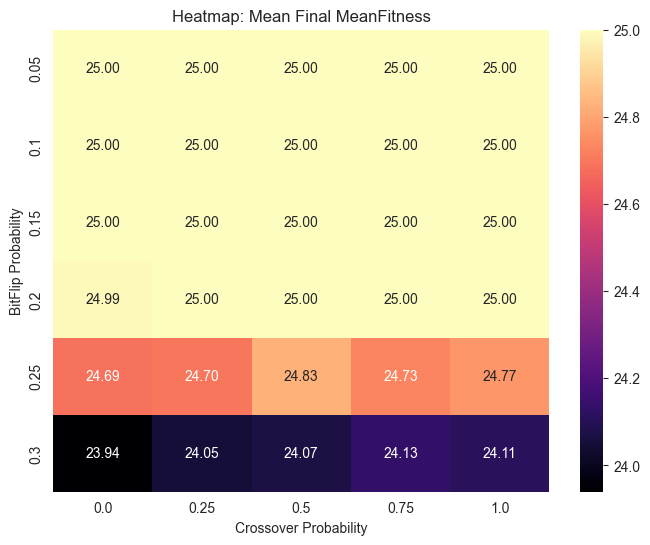

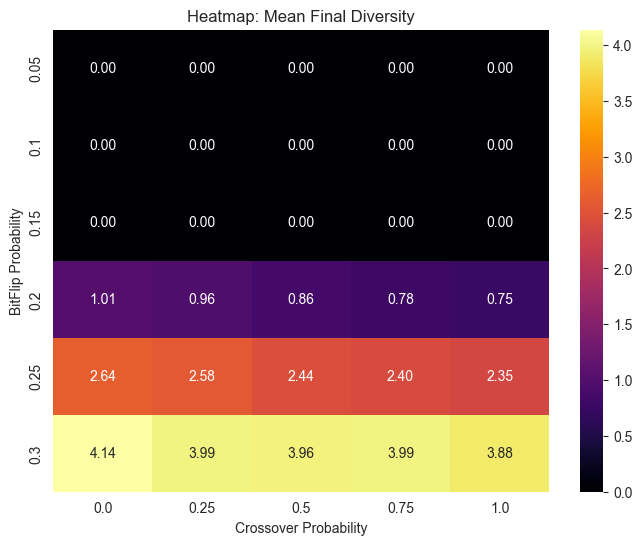

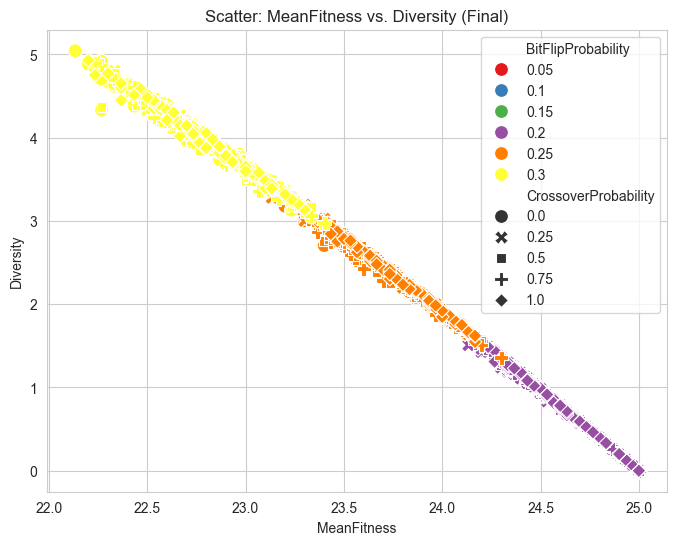

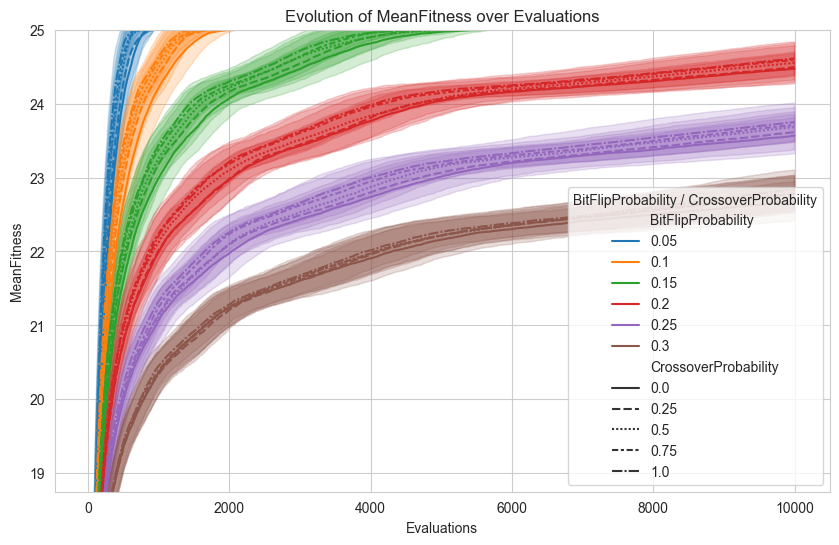

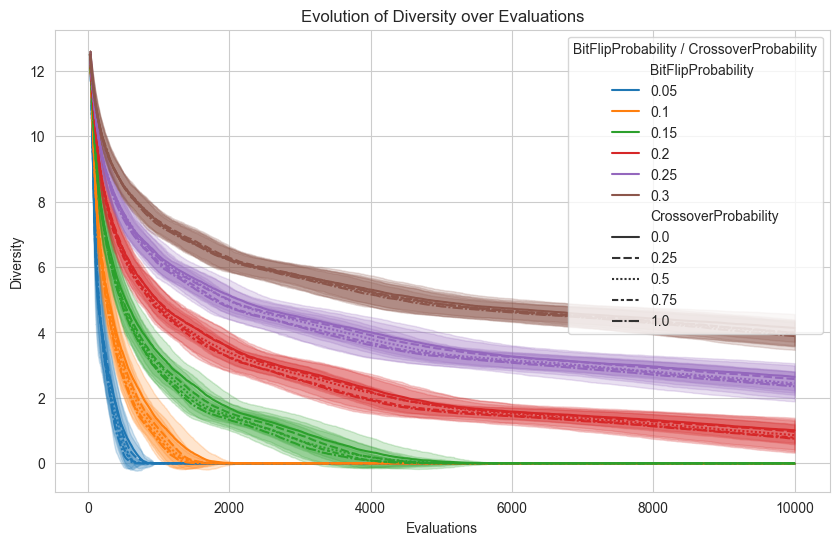

C:\Users\rafac\AppData\Local\Temp\ipykernel_10132\2718358213.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


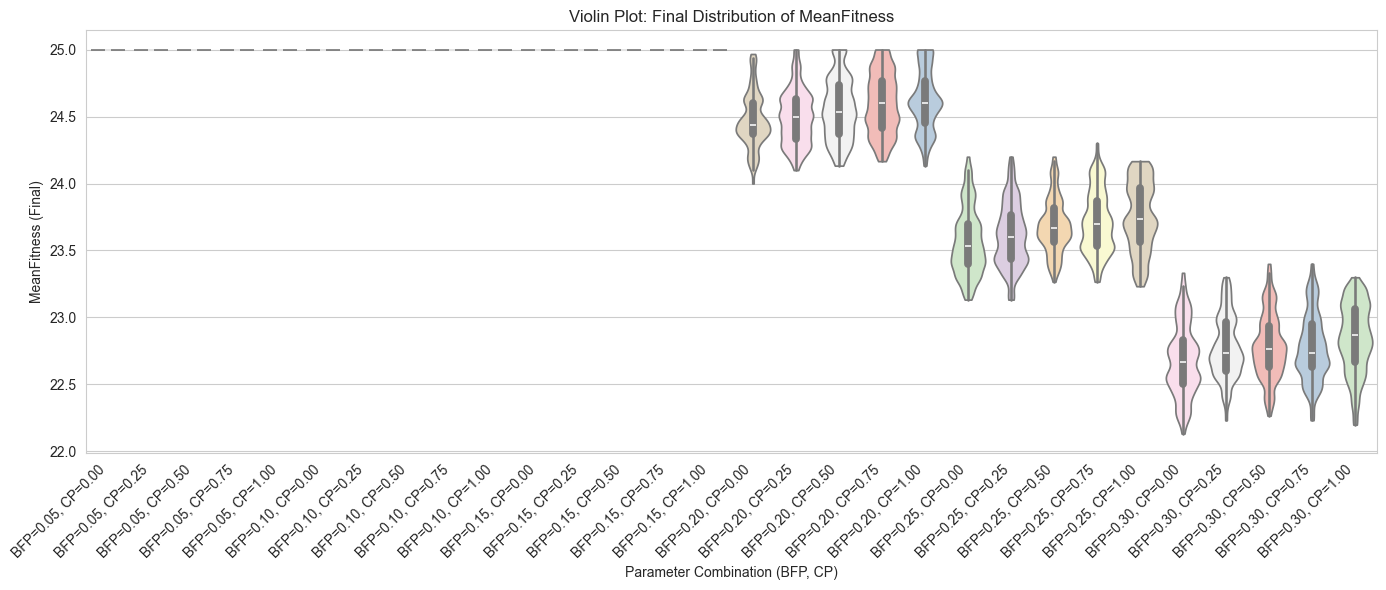

C:\Users\rafac\AppData\Local\Temp\ipykernel_10132\2718358213.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


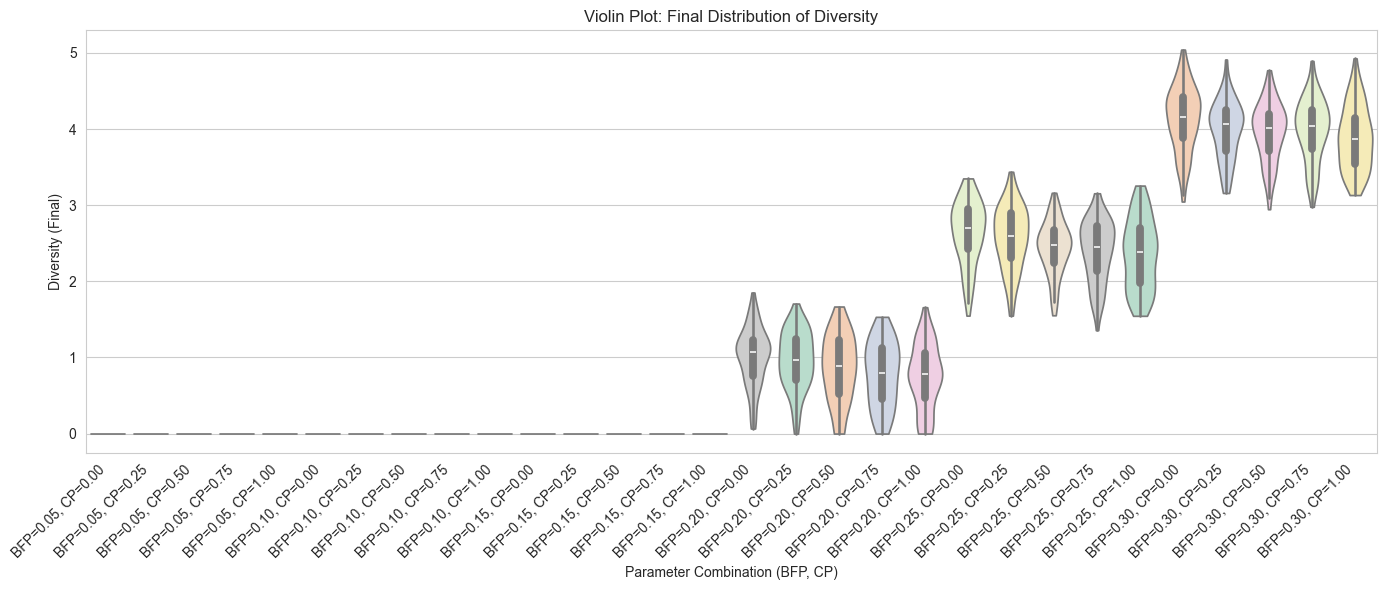

2025-02-16 23:33:03,668 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-16 23:33:03,673 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


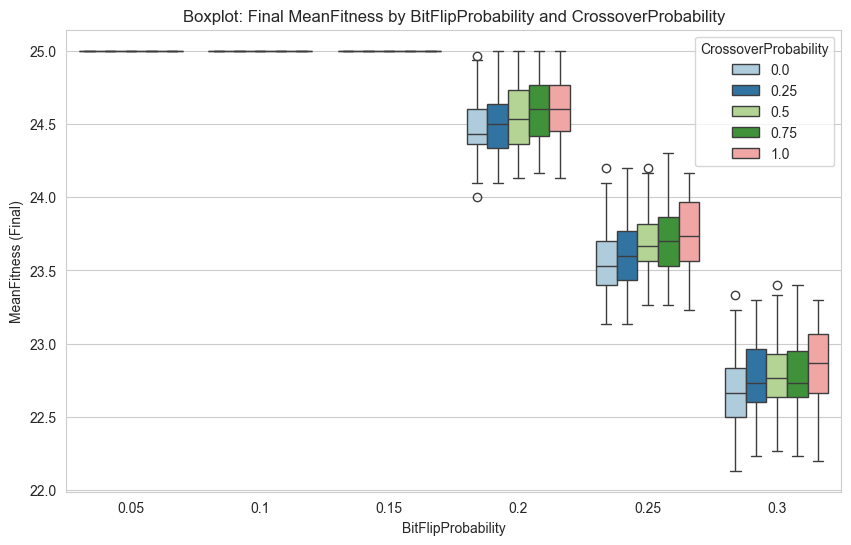

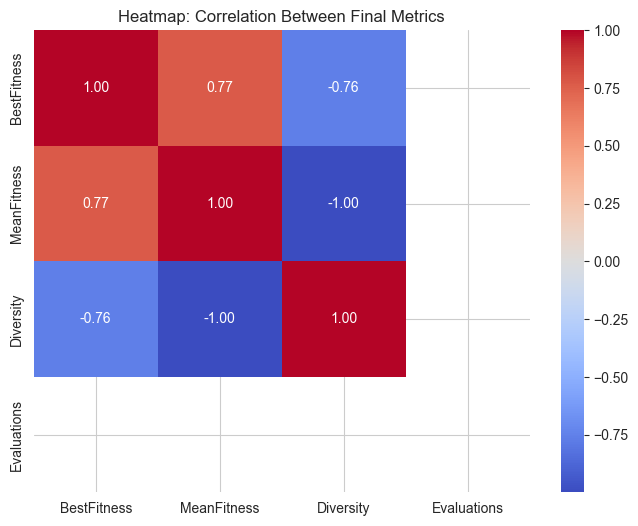

In [4]:
df = load_df(25, "false")
df = df[df["Evaluations"] <= 10000]
display(df)
tables = generate_tables(df)
print("Resumen de Fitness Final:")
display(tables["fitness_summary"])
print("\nResumen de Diversidad Final:")
display(tables["diversity_summary"])
print("\nResumen de Evaluaciones:")
display(tables["evaluations_summary"])
generate_plots(df)

2025-02-16 23:33:04,174 - INFO - Found 2970 CSV files in Data/ProS_25/Es_true
Processing files: 100%|██████████| 2970/2970 [00:06<00:00, 439.60it/s]
2025-02-16 23:33:11,680 - INFO - Combined DataFrame shape: (14363783, 10)


Evaluations  BestFitness  MeanFitness  Diversity  UniqueIndividuals  \
0                  31           18      13.4000    12.4644                 30   
1                  32           18      13.5667    12.4023                 29   
2                  33           18      13.8333    12.4253                 29   
3                  34           18      13.9000    12.4207                 28   
4                  35           18      14.0667    12.3908                 27   
...               ...          ...          ...        ...                ...   
14363778        19996           24      23.6000     2.5885                 24   
14363779        19997           24      23.6000     2.5885                 24   
14363780        19998           24      23.6000     2.5885                 24   
14363781        19999           24      23.6000     2.5885                 24   
14363782        20000           24      23.6000     2.5885                 24   

          PopulationSize  ProblemSize  BitFlipProbability  \
0                     30           25                0.05   
1                     30           25                0.05   
2                     30           25                0.05   
3                     30           25                0.05   
4                     30           25                0.05   
...                  ...          ...                 ...   
14363778              30           25                0.30   
14363779              30           25                0.30   
14363780              30           25                0.30   
14363781              30           25                0.30   
14363782              30           25                0.30   

          CrossoverProbability  RandomSeed  
0                          0.0          19  
1                          0.0          19  
2                          0.0          19  
3                          0.0          19  
4                          0.0          19  
...                        ...         ...  
14363778                   1.0          96  
14363779                   1.0          96  
14363780                   1.0          96  
14363781                   1.0          96  
14363782                   1.0          96  

[14363783 rows x 10 columns]

Fitness Summary:


BitFlipProbability  CrossoverProbability  MeanFinalFitness  \
0                 0.05                  0.00         23.556219   
1                 0.05                  0.25         23.398646   
2                 0.05                  0.50         23.319189   
3                 0.05                  0.75         23.305389   
4                 0.05                  1.00         23.206399   
5                 0.10                  0.00         23.334341   
6                 0.10                  0.25         23.173734   
7                 0.10                  0.50         23.148485   
8                 0.10                  0.75         23.095618   
9                 0.10                  1.00         23.060271   
10                0.15                  0.00         23.288551   
11                0.15                  0.25         23.255887   
12                0.15                  0.50         23.020538   
13                0.15                  0.75         22.963303   
14                0.15                  1.00         23.077774   
15                0.20                  0.00         23.225255   
16                0.20                  0.25         23.238721   
17                0.20                  0.50         23.174408   
18                0.20                  0.75         23.038045   
19                0.20                  1.00         23.145456   
20                0.25                  0.00         23.292257   
21                0.25                  0.25         23.310772   
22                0.25                  0.50         23.282490   
23                0.25                  0.75         23.315820   
24                0.25                  1.00         23.259596   
25                0.30                  0.00         23.112461   
26                0.30                  0.25         22.996297   
27                0.30                  0.50         23.139728   
28                0.30                  0.75         23.136025   
29                0.30                  1.00         23.138385   

    StdFinalFitness  MaxFinalFitness  MinFinalFitness  
0          0.478475          24.0333          21.7667  
1          0.592443          24.0333          20.8667  
2          0.580047          24.0333          21.2000  
3          0.425960          24.0333          22.0000  
4          0.620063          24.0333          20.5000  
5          0.573856          24.0333          19.9333  
6          0.667280          24.0333          20.7333  
7          0.628452          24.0333          20.5667  
8          0.612371          24.0333          21.1333  
9          0.810804          24.0333          18.3000  
10         0.524111          24.0333          21.5667  
11         0.532135          24.0333          20.9333  
12         0.704540          24.0333          20.6667  
13         0.712849          24.0333          20.7333  
14         0.641161          24.0333          21.2333  
15         0.520030          24.0333          20.8333  
16         0.517902          24.0333          21.5000  
17         0.701840          24.0333          19.9333  
18         0.728866          24.0333          19.8000  
19         0.609733          24.0333          20.6667  
20         0.511581          24.0333          21.6667  
21         0.416138          24.0333          22.1667  
22         0.650725          24.0333          19.8667  
23         0.487742          24.0333          21.4000  
24         0.508877          24.0333          21.5667  
25         0.278181          23.5333          21.4333  
26         0.551541          23.5333          20.4333  
27         0.353273          23.5333          21.3000  
28         0.401829          23.5667          20.7000  
29         0.353163          23.6000          21.5000


Diversity Summary:


BitFlipProbability  CrossoverProbability  MeanFinalDiversity  \
0                 0.05                  0.00            1.517801   
1                 0.05                  0.25            1.854219   
2                 0.05                  0.50            2.015048   
3                 0.05                  0.75            2.139714   
4                 0.05                  1.00            2.317820   
5                 0.10                  0.00            2.475816   
6                 0.10                  0.25            2.781889   
7                 0.10                  0.50            2.908922   
8                 0.10                  0.75            2.981441   
9                 0.10                  1.00            3.097906   
10                0.15                  0.00            2.881710   
11                0.15                  0.25            2.944757   
12                0.15                  0.50            3.314819   
13                0.15                  0.75            3.437711   
14                0.15                  1.00            3.318216   
15                0.20                  0.00            3.126319   
16                0.20                  0.25            3.120005   
17                0.20                  0.50            3.196985   
18                0.20                  0.75            3.441428   
19                0.20                  1.00            3.303469   
20                0.25                  0.00            3.085337   
21                0.25                  0.25            3.068036   
22                0.25                  0.50            3.100318   
23                0.25                  0.75            3.069778   
24                0.25                  1.00            3.165841   
25                0.30                  0.00            3.440753   
26                0.30                  0.25            3.613026   
27                0.30                  0.50            3.397309   
28                0.30                  0.75            3.397700   
29                0.30                  1.00            3.398749   

    StdFinalDiversity  MaxFinalDiversity  MinFinalDiversity  
0            0.700188             3.5862             0.0667  
1            0.793695             4.8115             0.0667  
2            0.827554             5.3333             0.1954  
3            0.664718             4.0230             0.1954  
4            0.901771             5.1241             0.1954  
5            0.689540             4.3172             1.1241  
6            0.926403             5.8897             1.3034  
7            0.843990             5.9494             1.4874  
8            0.749163             5.0460             1.5793  
9            1.122210             9.3724             1.0460  
10           0.789367             5.6207             1.6345  
11           0.787073             6.0690             1.3563  
12           1.013856             6.6483             1.5471  
13           1.046012             6.2529             1.7310  
14           0.948848             5.8460             1.7172  
15           0.775345             6.0529             1.7172  
16           0.814461             5.7264             1.8138  
17           1.021128             7.6230             1.8184  
18           1.086243             7.8529             1.7770  
19           0.948352             6.6483             1.7908  
20           0.834633             5.3563             1.7816  
21           0.685573             4.7563             1.7586  
22           1.001554             7.6414             1.7954  
23           0.791030             5.9586             1.7908  
24           0.825301             5.8828             1.8552  
25           0.450861             6.0345             2.7448  
26           0.847961             7.4414             2.7172  
27           0.568701             6.2874             2.7080  
28           0.629045             6.9908             2.6644  
29           0.570206             5


Evaluations Summary:


BitFlipProbability  CrossoverProbability  MeanEvaluations  StdEvaluations  \
0                 0.05                  0.00       446.454545       97.023380   
1                 0.05                  0.25       401.797980       93.049798   
2                 0.05                  0.50       371.575758       99.593571   
3                 0.05                  0.75       336.666667       73.466499   
4                 0.05                  1.00       305.929293       71.445891   
5                 0.10                  0.00       712.929293      215.127454   
6                 0.10                  0.25       611.707071      194.693440   
7                 0.10                  0.50       548.313131      170.040610   
8                 0.10                  0.75       510.141414      160.283996   
9                 0.10                  1.00       473.434343      149.540668   
10                0.15                  0.00      1355.858586      555.313260   
11                0.15                  0.25      1240.939394      476.055622   
12                0.15                  0.50      1026.090909      495.737362   
13                0.15                  0.75       962.939394      445.291714   
14                0.15                  1.00       928.888889      381.977772   
15                0.20                  0.00      2904.656566     1477.597189   
16                0.20                  0.25      2802.676768     1397.475996   
17                0.20                  0.50      2736.606061     1367.991122   
18                0.20                  0.75      2344.979798     1201.644197   
19                0.20                  1.00      2365.111111     1259.052437   
20                0.25                  0.00      8533.595960     4873.615123   
21                0.25                  0.25      7791.949495     4262.692402   
22                0.25                  0.50      7964.888889     4576.653576   
23                0.25                  0.75      7405.545455     4012.869265   
24                0.25                  1.00      6945.191919     3937.774770   
25                0.30                  0.00     17229.474747     4334.999895   
26                0.30                  0.25     16177.636364     6150.945160   
27                0.30                  0.50     17308.696970     4721.345894   
28                0.30                  0.75     16916.040404     4876.200999   
29                0.30                  1.00     16328.000000     5091.621920   

    MinEvaluations  MaxEvaluations  
0              205             754  
1              163             592  
2              154             718  
3              195             555  
4              166             541  
5              204            1316  
6              231            1048  
7              180             911  
8              192             921  
9              115             875  
10             476            2834  
11             387            2605  
12             282            3083  
13             298            2007  
14             323            2262  
15             518           10281  
16             536            7887  
17             236            8137  
18             309            5595  
19             399            6376  
20            1474           20000  
21            1252           20000  
22             370           20000  
23             504           18978  
24            1176           20000  
25            2088           20000  
26             839           20000  
27            2033           20000  
28             857           20000  
29            2000           20000

Resumen de Fitness Final:


BitFlipProbability  CrossoverProbability  MeanFinalFitness  \
0                 0.05                  0.00         23.556219   
1                 0.05                  0.25         23.398646   
2                 0.05                  0.50         23.319189   
3                 0.05                  0.75         23.305389   
4                 0.05                  1.00         23.206399   
5                 0.10                  0.00         23.334341   
6                 0.10                  0.25         23.173734   
7                 0.10                  0.50         23.148485   
8                 0.10                  0.75         23.095618   
9                 0.10                  1.00         23.060271   
10                0.15                  0.00         23.288551   
11                0.15                  0.25         23.255887   
12                0.15                  0.50         23.020538   
13                0.15                  0.75         22.963303   
14                0.15                  1.00         23.077774   
15                0.20                  0.00         23.225255   
16                0.20                  0.25         23.238721   
17                0.20                  0.50         23.174408   
18                0.20                  0.75         23.038045   
19                0.20                  1.00         23.145456   
20                0.25                  0.00         23.292257   
21                0.25                  0.25         23.310772   
22                0.25                  0.50         23.282490   
23                0.25                  0.75         23.315820   
24                0.25                  1.00         23.259596   
25                0.30                  0.00         23.112461   
26                0.30                  0.25         22.996297   
27                0.30                  0.50         23.139728   
28                0.30                  0.75         23.136025   
29                0.30                  1.00         23.138385   

    StdFinalFitness  MaxFinalFitness  MinFinalFitness  
0          0.478475          24.0333          21.7667  
1          0.592443          24.0333          20.8667  
2          0.580047          24.0333          21.2000  
3          0.425960          24.0333          22.0000  
4          0.620063          24.0333          20.5000  
5          0.573856          24.0333          19.9333  
6          0.667280          24.0333          20.7333  
7          0.628452          24.0333          20.5667  
8          0.612371          24.0333          21.1333  
9          0.810804          24.0333          18.3000  
10         0.524111          24.0333          21.5667  
11         0.532135          24.0333          20.9333  
12         0.704540          24.0333          20.6667  
13         0.712849          24.0333          20.7333  
14         0.641161          24.0333          21.2333  
15         0.520030          24.0333          20.8333  
16         0.517902          24.0333          21.5000  
17         0.701840          24.0333          19.9333  
18         0.728866          24.0333          19.8000  
19         0.609733          24.0333          20.6667  
20         0.511581          24.0333          21.6667  
21         0.416138          24.0333          22.1667  
22         0.650725          24.0333          19.8667  
23         0.487742          24.0333          21.4000  
24         0.508877          24.0333          21.5667  
25         0.278181          23.5333          21.4333  
26         0.551541          23.5333          20.4333  
27         0.353273          23.5333          21.3000  
28         0.401829          23.5667          20.7000  
29         0.353163          23.6000          21.5000


Resumen de Diversidad Final:


BitFlipProbability  CrossoverProbability  MeanFinalDiversity  \
0                 0.05                  0.00            1.517801   
1                 0.05                  0.25            1.854219   
2                 0.05                  0.50            2.015048   
3                 0.05                  0.75            2.139714   
4                 0.05                  1.00            2.317820   
5                 0.10                  0.00            2.475816   
6                 0.10                  0.25            2.781889   
7                 0.10                  0.50            2.908922   
8                 0.10                  0.75            2.981441   
9                 0.10                  1.00            3.097906   
10                0.15                  0.00            2.881710   
11                0.15                  0.25            2.944757   
12                0.15                  0.50            3.314819   
13                0.15                  0.75            3.437711   
14                0.15                  1.00            3.318216   
15                0.20                  0.00            3.126319   
16                0.20                  0.25            3.120005   
17                0.20                  0.50            3.196985   
18                0.20                  0.75            3.441428   
19                0.20                  1.00            3.303469   
20                0.25                  0.00            3.085337   
21                0.25                  0.25            3.068036   
22                0.25                  0.50            3.100318   
23                0.25                  0.75            3.069778   
24                0.25                  1.00            3.165841   
25                0.30                  0.00            3.440753   
26                0.30                  0.25            3.613026   
27                0.30                  0.50            3.397309   
28                0.30                  0.75            3.397700   
29                0.30                  1.00            3.398749   

    StdFinalDiversity  MaxFinalDiversity  MinFinalDiversity  
0            0.700188             3.5862             0.0667  
1            0.793695             4.8115             0.0667  
2            0.827554             5.3333             0.1954  
3            0.664718             4.0230             0.1954  
4            0.901771             5.1241             0.1954  
5            0.689540             4.3172             1.1241  
6            0.926403             5.8897             1.3034  
7            0.843990             5.9494             1.4874  
8            0.749163             5.0460             1.5793  
9            1.122210             9.3724             1.0460  
10           0.789367             5.6207             1.6345  
11           0.787073             6.0690             1.3563  
12           1.013856             6.6483             1.5471  
13           1.046012             6.2529             1.7310  
14           0.948848             5.8460             1.7172  
15           0.775345             6.0529             1.7172  
16           0.814461             5.7264             1.8138  
17           1.021128             7.6230             1.8184  
18           1.086243             7.8529             1.7770  
19           0.948352             6.6483             1.7908  
20           0.834633             5.3563             1.7816  
21           0.685573             4.7563             1.7586  
22           1.001554             7.6414             1.7954  
23           0.791030             5.9586             1.7908  
24           0.825301             5.8828             1.8552  
25           0.450861             6.0345             2.7448  
26           0.847961             7.4414             2.7172  
27           0.568701             6.2874             2.7080  
28           0.629045             6.9908             2.6644  
29           0.570206             5


Resumen de Evaluaciones:


BitFlipProbability  CrossoverProbability  MeanEvaluations  StdEvaluations  \
0                 0.05                  0.00       446.454545       97.023380   
1                 0.05                  0.25       401.797980       93.049798   
2                 0.05                  0.50       371.575758       99.593571   
3                 0.05                  0.75       336.666667       73.466499   
4                 0.05                  1.00       305.929293       71.445891   
5                 0.10                  0.00       712.929293      215.127454   
6                 0.10                  0.25       611.707071      194.693440   
7                 0.10                  0.50       548.313131      170.040610   
8                 0.10                  0.75       510.141414      160.283996   
9                 0.10                  1.00       473.434343      149.540668   
10                0.15                  0.00      1355.858586      555.313260   
11                0.15                  0.25      1240.939394      476.055622   
12                0.15                  0.50      1026.090909      495.737362   
13                0.15                  0.75       962.939394      445.291714   
14                0.15                  1.00       928.888889      381.977772   
15                0.20                  0.00      2904.656566     1477.597189   
16                0.20                  0.25      2802.676768     1397.475996   
17                0.20                  0.50      2736.606061     1367.991122   
18                0.20                  0.75      2344.979798     1201.644197   
19                0.20                  1.00      2365.111111     1259.052437   
20                0.25                  0.00      8533.595960     4873.615123   
21                0.25                  0.25      7791.949495     4262.692402   
22                0.25                  0.50      7964.888889     4576.653576   
23                0.25                  0.75      7405.545455     4012.869265   
24                0.25                  1.00      6945.191919     3937.774770   
25                0.30                  0.00     17229.474747     4334.999895   
26                0.30                  0.25     16177.636364     6150.945160   
27                0.30                  0.50     17308.696970     4721.345894   
28                0.30                  0.75     16916.040404     4876.200999   
29                0.30                  1.00     16328.000000     5091.621920   

    MinEvaluations  MaxEvaluations  
0              205             754  
1              163             592  
2              154             718  
3              195             555  
4              166             541  
5              204            1316  
6              231            1048  
7              180             911  
8              192             921  
9              115             875  
10             476            2834  
11             387            2605  
12             282            3083  
13             298            2007  
14             323            2262  
15             518           10281  
16             536            7887  
17             236            8137  
18             309            5595  
19             399            6376  
20            1474           20000  
21            1252           20000  
22             370           20000  
23             504           18978  
24            1176           20000  
25            2088           20000  
26             839           20000  
27            2033           20000  
28             857           20000  
29            2000           20000

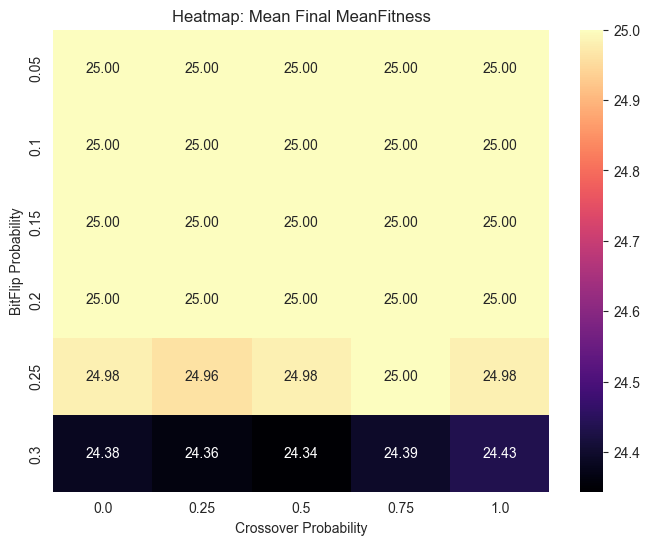

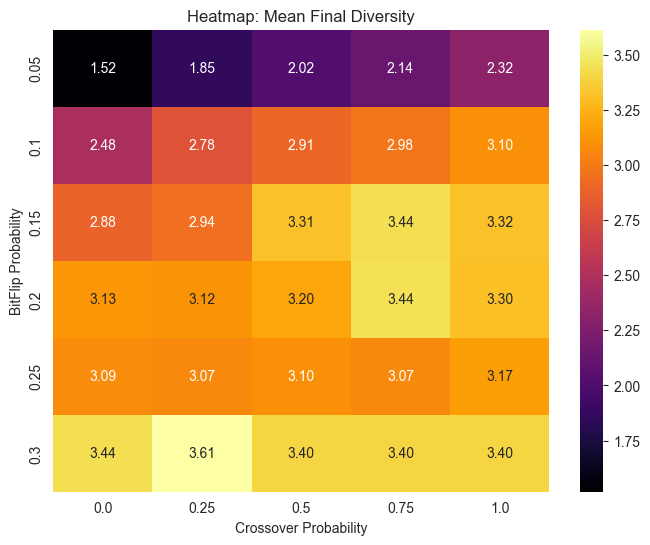

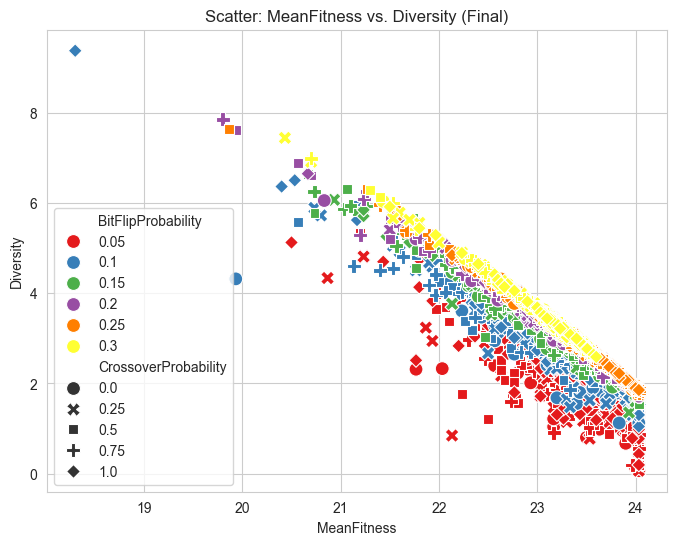

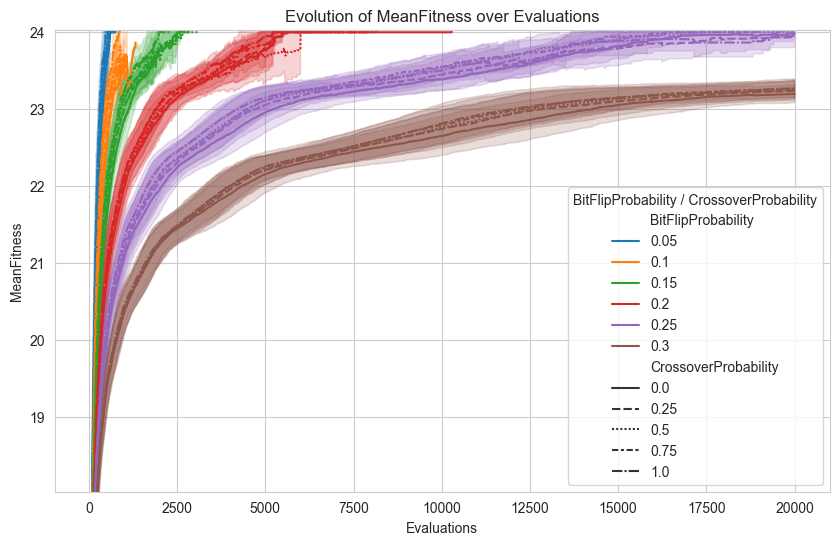

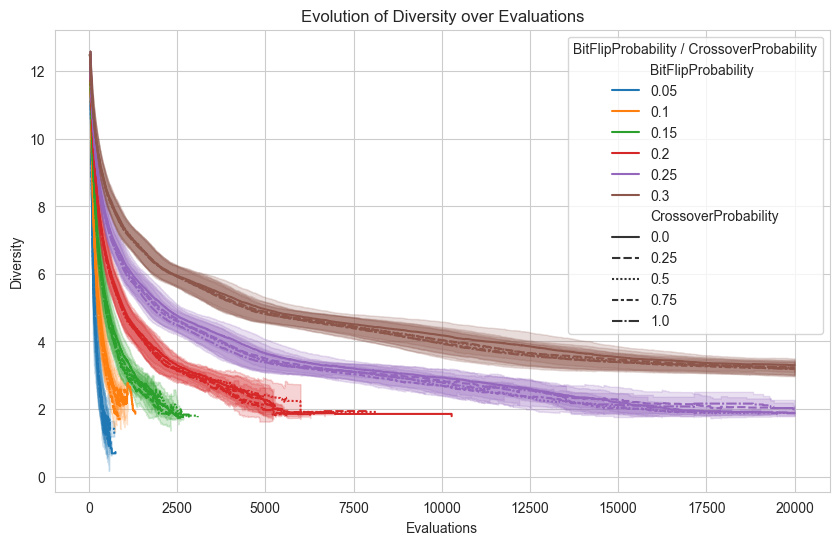

C:\Users\rafac\AppData\Local\Temp\ipykernel_10132\2718358213.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


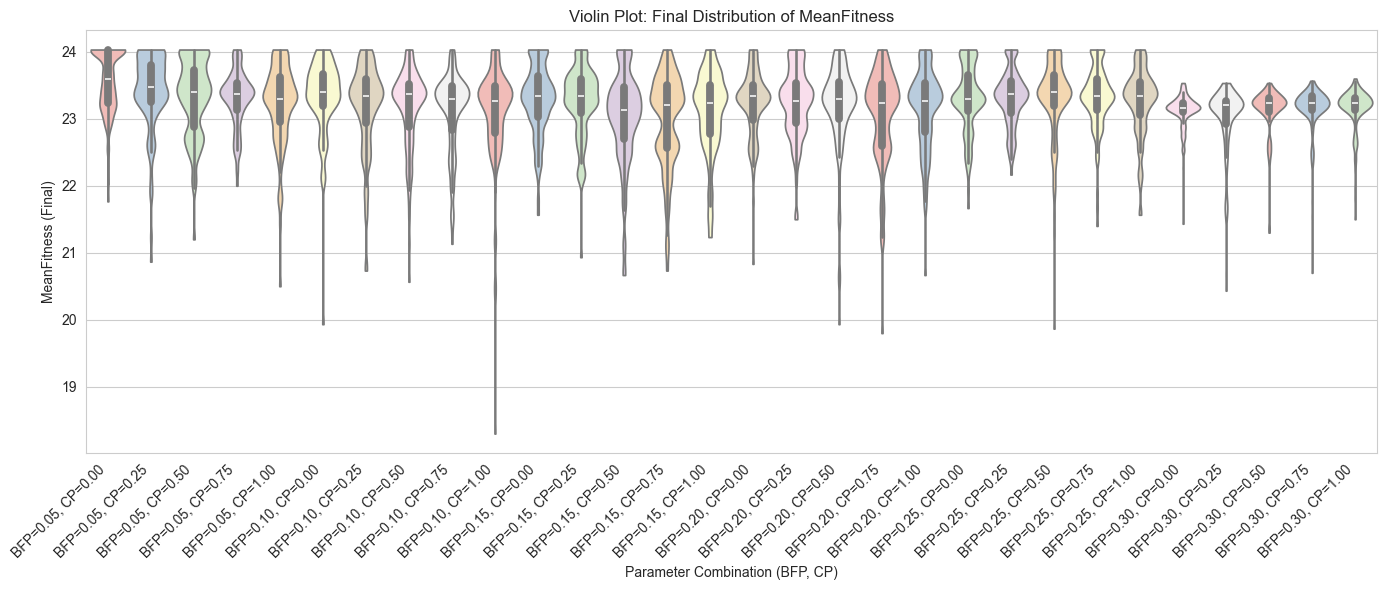

C:\Users\rafac\AppData\Local\Temp\ipykernel_10132\2718358213.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


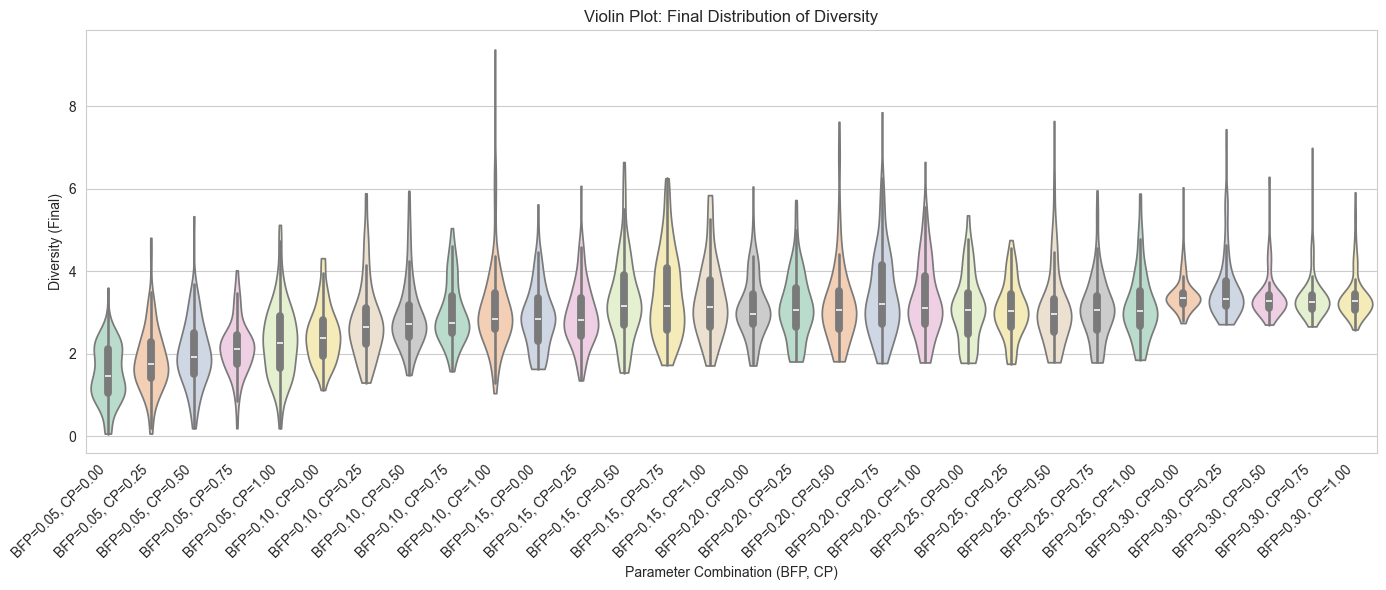

2025-02-16 23:34:59,372 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-16 23:34:59,376 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


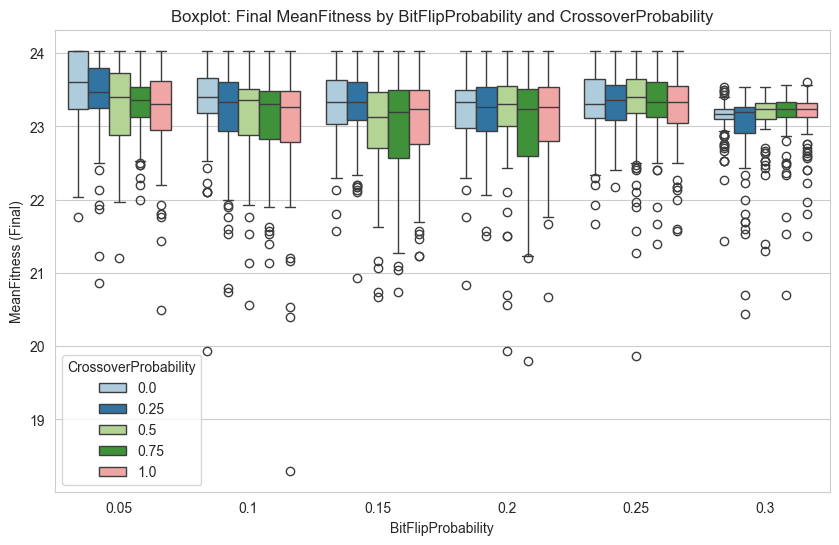

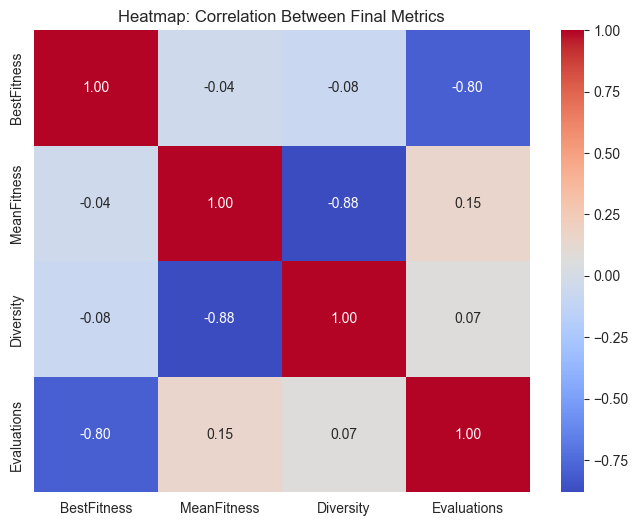

In [5]:
df = load_df(25, "true")
# df = df[df["Evaluations"] <= 100000]
display(df)
tables = generate_tables(df)
print("Resumen de Fitness Final:")
display(tables["fitness_summary"])
print("\nResumen de Diversidad Final:")
display(tables["diversity_summary"])
print("\nResumen de Evaluaciones:")
display(tables["evaluations_summary"])
generate_plots(df)

2025-02-16 23:34:59,697 - INFO - Found 2970 CSV files in Data/ProS_50/Es_false
Processing files: 100%|██████████| 2970/2970 [00:10<00:00, 293.11it/s]
2025-02-16 23:35:11,020 - INFO - Combined DataFrame shape: (59310900, 10)


Evaluations  BestFitness  MeanFitness  Diversity  UniqueIndividuals  \
0                  31           33      25.1333    25.1954                 30   
1                  32           33      25.5667    25.0736                 30   
2                  33           33      25.8333    25.0092                 29   
3                  34           33      26.0333    25.0276                 29   
4                  35           33      26.1333    24.9931                 29   
...               ...          ...          ...        ...                ...   
59300895         9996           44      41.2333    13.8644                 30   
59300896         9997           44      41.2333    13.8644                 30   
59300897         9998           44      41.2333    13.8644                 30   
59300898         9999           44      41.2333    13.8644                 30   
59300899        10000           44      41.2333    13.8644                 30   

          PopulationSize  ProblemSize  BitFlipProbability  \
0                     30           50                0.05   
1                     30           50                0.05   
2                     30           50                0.05   
3                     30           50                0.05   
4                     30           50                0.05   
...                  ...          ...                 ...   
59300895              30           50                0.30   
59300896              30           50                0.30   
59300897              30           50                0.30   
59300898              30           50                0.30   
59300899              30           50                0.30   

          CrossoverProbability  RandomSeed  
0                          0.0           1  
1                          0.0           1  
2                          0.0           1  
3                          0.0           1  
4                          0.0           1  
...                        ...         ...  
59300895                   1.0          99  
59300896                   1.0          99  
59300897                   1.0          99  
59300898                   1.0          99  
59300899                   1.0          99  

[29610900 rows x 10 columns]

Fitness Summary:


BitFlipProbability  CrossoverProbability  MeanFinalFitness  \
0                 0.05                  0.00         50.000000   
1                 0.05                  0.25         50.000000   
2                 0.05                  0.50         50.000000   
3                 0.05                  0.75         50.000000   
4                 0.05                  1.00         50.000000   
5                 0.10                  0.00         49.074415   
6                 0.10                  0.25         49.211117   
7                 0.10                  0.50         49.354881   
8                 0.10                  0.75         49.470373   
9                 0.10                  1.00         49.476768   
10                0.15                  0.00         46.190234   
11                0.15                  0.25         46.495960   
12                0.15                  0.50         46.657236   
13                0.15                  0.75         46.829632   
14                0.15                  1.00         47.018848   
15                0.20                  0.00         43.808086   
16                0.20                  0.25         44.051851   
17                0.20                  0.50         44.226266   
18                0.20                  0.75         44.366670   
19                0.20                  1.00         44.499660   
20                0.25                  0.00         41.837373   
21                0.25                  0.25         41.984512   
22                0.25                  0.50         42.149831   
23                0.25                  0.75         42.197308   
24                0.25                  1.00         42.335352   
25                0.30                  0.00         40.238047   
26                0.30                  0.25         40.314474   
27                0.30                  0.50         40.435690   
28                0.30                  0.75         40.473737   
29                0.30                  1.00         40.530306   

    StdFinalFitness  MaxFinalFitness  MinFinalFitness  
0          0.000000          50.0000          50.0000  
1          0.000000          50.0000          50.0000  
2          0.000000          50.0000          50.0000  
3          0.000000          50.0000          50.0000  
4          0.000000          50.0000          50.0000  
5          0.309262          49.8333          48.1667  
6          0.247164          50.0000          48.3333  
7          0.242171          50.0000          48.9333  
8          0.251342          50.0000          49.0333  
9          0.251549          50.0000          49.0333  
10         0.391875          47.4000          45.2667  
11         0.387360          47.5333          45.5333  
12         0.388148          47.6000          45.4000  
13         0.351543          47.6000          45.9000  
14         0.316019          47.7333          46.1333  
15         0.432024          44.8000          42.8667  
16         0.371980          44.7667          43.2333  
17         0.406000          45.1667          43.3667  
18         0.382856          45.4000          43.4333  
19         0.362800          45.6667          43.6000  
20         0.383659          42.8333          41.0333  
21         0.364752          42.8333          41.2667  
22         0.374933          43.2667          41.5333  
23         0.374309          43.1333          41.4000  
24         0.326693          43.1667          41.3667  
25         0.376164          41.2667          39.3667  
26         0.315694          41.1000          39.4000  
27         0.338471          41.1333          39.5667  
28         0.316772          41.4333          39.7000  
29         0.334725          41.4667          39.6667


Diversity Summary:


BitFlipProbability  CrossoverProbability  MeanFinalDiversity  \
0                 0.05                  0.00            0.000000   
1                 0.05                  0.25            0.000000   
2                 0.05                  0.50            0.000000   
3                 0.05                  0.75            0.000000   
4                 0.05                  1.00            0.000000   
5                 0.10                  0.00            1.655524   
6                 0.10                  0.25            1.451779   
7                 0.10                  0.50            1.210166   
8                 0.10                  0.75            1.015651   
9                 0.10                  1.00            1.000022   
10                0.15                  0.00            6.428163   
11                0.15                  0.25            6.031835   
12                0.15                  0.50            5.851710   
13                0.15                  0.75            5.630790   
14                0.15                  1.00            5.360037   
15                0.20                  0.00           10.178245   
16                0.20                  0.25            9.921932   
17                0.20                  0.50            9.710813   
18                0.20                  0.75            9.582743   
19                0.20                  1.00            9.381308   
20                0.25                  0.00           13.034512   
21                0.25                  0.25           12.890143   
22                0.25                  0.50           12.776669   
23                0.25                  0.75           12.760524   
24                0.25                  1.00           12.580890   
25                0.30                  0.00           15.310875   
26                0.30                  0.25           15.246061   
27                0.30                  0.50           15.094114   
28                0.30                  0.75           15.035155   
29                0.30                  1.00           14.986113   

    StdFinalDiversity  MaxFinalDiversity  MinFinalDiversity  
0            0.000000             0.0000             0.0000  
1            0.000000             0.0000             0.0000  
2            0.000000             0.0000             0.0000  
3            0.000000             0.0000             0.0000  
4            0.000000             0.0000             0.0000  
5            0.528469             3.2667             0.3149  
6            0.446517             3.0437             0.0000  
7            0.441904             1.9126             0.0000  
8            0.474562             1.8276             0.0000  
9            0.472611             1.8690             0.0000  
10           0.629809             8.1563             4.3816  
11           0.630245             7.3793             4.4414  
12           0.633189             7.4115             4.0184  
13           0.556978             6.8322             4.3448  
14           0.518659             6.8966             4.2115  
15           0.676497            11.7862             8.8184  
16           0.563716            11.0966             8.7287  
17           0.655932            11.0115             8.0713  
18           0.601327            11.2345             7.7839  
19           0.547536            10.8115             7.4023  
20           0.591654            14.1448            11.5126  
21           0.520528            14.1931            11.8851  
22           0.544638            13.8920            11.1494  
23           0.517959            14.0000            11.3977  
24           0.482568            14.0943            11.3770  
25           0.514233            16.5126            14.0138  
26           0.410946            16.1931            14.3471  
27           0.480139            16.3241            14.0000  
28           0.413889            15.8644            14.0115  
29           0.470354            16


Evaluations Summary:


BitFlipProbability  CrossoverProbability  MeanEvaluations  StdEvaluations  \
0                 0.05                  0.00          10000.0             0.0   
1                 0.05                  0.25          10000.0             0.0   
2                 0.05                  0.50          10000.0             0.0   
3                 0.05                  0.75          10000.0             0.0   
4                 0.05                  1.00          10000.0             0.0   
5                 0.10                  0.00          10000.0             0.0   
6                 0.10                  0.25          10000.0             0.0   
7                 0.10                  0.50          10000.0             0.0   
8                 0.10                  0.75          10000.0             0.0   
9                 0.10                  1.00          10000.0             0.0   
10                0.15                  0.00          10000.0             0.0   
11                0.15                  0.25          10000.0             0.0   
12                0.15                  0.50          10000.0             0.0   
13                0.15                  0.75          10000.0             0.0   
14                0.15                  1.00          10000.0             0.0   
15                0.20                  0.00          10000.0             0.0   
16                0.20                  0.25          10000.0             0.0   
17                0.20                  0.50          10000.0             0.0   
18                0.20                  0.75          10000.0             0.0   
19                0.20                  1.00          10000.0             0.0   
20                0.25                  0.00          10000.0             0.0   
21                0.25                  0.25          10000.0             0.0   
22                0.25                  0.50          10000.0             0.0   
23                0.25                  0.75          10000.0             0.0   
24                0.25                  1.00          10000.0             0.0   
25                0.30                  0.00          10000.0             0.0   
26                0.30                  0.25          10000.0             0.0   
27                0.30                  0.50          10000.0             0.0   
28                0.30                  0.75          10000.0             0.0   
29                0.30                  1.00          10000.0             0.0   

    MinEvaluations  MaxEvaluations  
0            10000           10000  
1            10000           10000  
2            10000           10000  
3            10000           10000  
4            10000           10000  
5            10000           10000  
6            10000           10000  
7            10000           10000  
8            10000           10000  
9            10000           10000  
10           10000           10000  
11           10000           10000  
12           10000           10000  
13           10000           10000  
14           10000           10000  
15           10000           10000  
16           10000           10000  
17           10000           10000  
18           10000           10000  
19           10000           10000  
20           10000           10000  
21           10000           10000  
22           10000           10000  
23           10000           10000  
24           10000           10000  
25           10000           10000  
26           10000           10000  
27           10000           10000  
28           10000           10000  
29           10000           10000

Resumen de Fitness Final:


BitFlipProbability  CrossoverProbability  MeanFinalFitness  \
0                 0.05                  0.00         50.000000   
1                 0.05                  0.25         50.000000   
2                 0.05                  0.50         50.000000   
3                 0.05                  0.75         50.000000   
4                 0.05                  1.00         50.000000   
5                 0.10                  0.00         49.074415   
6                 0.10                  0.25         49.211117   
7                 0.10                  0.50         49.354881   
8                 0.10                  0.75         49.470373   
9                 0.10                  1.00         49.476768   
10                0.15                  0.00         46.190234   
11                0.15                  0.25         46.495960   
12                0.15                  0.50         46.657236   
13                0.15                  0.75         46.829632   
14                0.15                  1.00         47.018848   
15                0.20                  0.00         43.808086   
16                0.20                  0.25         44.051851   
17                0.20                  0.50         44.226266   
18                0.20                  0.75         44.366670   
19                0.20                  1.00         44.499660   
20                0.25                  0.00         41.837373   
21                0.25                  0.25         41.984512   
22                0.25                  0.50         42.149831   
23                0.25                  0.75         42.197308   
24                0.25                  1.00         42.335352   
25                0.30                  0.00         40.238047   
26                0.30                  0.25         40.314474   
27                0.30                  0.50         40.435690   
28                0.30                  0.75         40.473737   
29                0.30                  1.00         40.530306   

    StdFinalFitness  MaxFinalFitness  MinFinalFitness  
0          0.000000          50.0000          50.0000  
1          0.000000          50.0000          50.0000  
2          0.000000          50.0000          50.0000  
3          0.000000          50.0000          50.0000  
4          0.000000          50.0000          50.0000  
5          0.309262          49.8333          48.1667  
6          0.247164          50.0000          48.3333  
7          0.242171          50.0000          48.9333  
8          0.251342          50.0000          49.0333  
9          0.251549          50.0000          49.0333  
10         0.391875          47.4000          45.2667  
11         0.387360          47.5333          45.5333  
12         0.388148          47.6000          45.4000  
13         0.351543          47.6000          45.9000  
14         0.316019          47.7333          46.1333  
15         0.432024          44.8000          42.8667  
16         0.371980          44.7667          43.2333  
17         0.406000          45.1667          43.3667  
18         0.382856          45.4000          43.4333  
19         0.362800          45.6667          43.6000  
20         0.383659          42.8333          41.0333  
21         0.364752          42.8333          41.2667  
22         0.374933          43.2667          41.5333  
23         0.374309          43.1333          41.4000  
24         0.326693          43.1667          41.3667  
25         0.376164          41.2667          39.3667  
26         0.315694          41.1000          39.4000  
27         0.338471          41.1333          39.5667  
28         0.316772          41.4333          39.7000  
29         0.334725          41.4667          39.6667


Resumen de Diversidad Final:


BitFlipProbability  CrossoverProbability  MeanFinalDiversity  \
0                 0.05                  0.00            0.000000   
1                 0.05                  0.25            0.000000   
2                 0.05                  0.50            0.000000   
3                 0.05                  0.75            0.000000   
4                 0.05                  1.00            0.000000   
5                 0.10                  0.00            1.655524   
6                 0.10                  0.25            1.451779   
7                 0.10                  0.50            1.210166   
8                 0.10                  0.75            1.015651   
9                 0.10                  1.00            1.000022   
10                0.15                  0.00            6.428163   
11                0.15                  0.25            6.031835   
12                0.15                  0.50            5.851710   
13                0.15                  0.75            5.630790   
14                0.15                  1.00            5.360037   
15                0.20                  0.00           10.178245   
16                0.20                  0.25            9.921932   
17                0.20                  0.50            9.710813   
18                0.20                  0.75            9.582743   
19                0.20                  1.00            9.381308   
20                0.25                  0.00           13.034512   
21                0.25                  0.25           12.890143   
22                0.25                  0.50           12.776669   
23                0.25                  0.75           12.760524   
24                0.25                  1.00           12.580890   
25                0.30                  0.00           15.310875   
26                0.30                  0.25           15.246061   
27                0.30                  0.50           15.094114   
28                0.30                  0.75           15.035155   
29                0.30                  1.00           14.986113   

    StdFinalDiversity  MaxFinalDiversity  MinFinalDiversity  
0            0.000000             0.0000             0.0000  
1            0.000000             0.0000             0.0000  
2            0.000000             0.0000             0.0000  
3            0.000000             0.0000             0.0000  
4            0.000000             0.0000             0.0000  
5            0.528469             3.2667             0.3149  
6            0.446517             3.0437             0.0000  
7            0.441904             1.9126             0.0000  
8            0.474562             1.8276             0.0000  
9            0.472611             1.8690             0.0000  
10           0.629809             8.1563             4.3816  
11           0.630245             7.3793             4.4414  
12           0.633189             7.4115             4.0184  
13           0.556978             6.8322             4.3448  
14           0.518659             6.8966             4.2115  
15           0.676497            11.7862             8.8184  
16           0.563716            11.0966             8.7287  
17           0.655932            11.0115             8.0713  
18           0.601327            11.2345             7.7839  
19           0.547536            10.8115             7.4023  
20           0.591654            14.1448            11.5126  
21           0.520528            14.1931            11.8851  
22           0.544638            13.8920            11.1494  
23           0.517959            14.0000            11.3977  
24           0.482568            14.0943            11.3770  
25           0.514233            16.5126            14.0138  
26           0.410946            16.1931            14.3471  
27           0.480139            16.3241            14.0000  
28           0.413889            15.8644            14.0115  
29           0.470354            16


Resumen de Evaluaciones:


BitFlipProbability  CrossoverProbability  MeanEvaluations  StdEvaluations  \
0                 0.05                  0.00          10000.0             0.0   
1                 0.05                  0.25          10000.0             0.0   
2                 0.05                  0.50          10000.0             0.0   
3                 0.05                  0.75          10000.0             0.0   
4                 0.05                  1.00          10000.0             0.0   
5                 0.10                  0.00          10000.0             0.0   
6                 0.10                  0.25          10000.0             0.0   
7                 0.10                  0.50          10000.0             0.0   
8                 0.10                  0.75          10000.0             0.0   
9                 0.10                  1.00          10000.0             0.0   
10                0.15                  0.00          10000.0             0.0   
11                0.15                  0.25          10000.0             0.0   
12                0.15                  0.50          10000.0             0.0   
13                0.15                  0.75          10000.0             0.0   
14                0.15                  1.00          10000.0             0.0   
15                0.20                  0.00          10000.0             0.0   
16                0.20                  0.25          10000.0             0.0   
17                0.20                  0.50          10000.0             0.0   
18                0.20                  0.75          10000.0             0.0   
19                0.20                  1.00          10000.0             0.0   
20                0.25                  0.00          10000.0             0.0   
21                0.25                  0.25          10000.0             0.0   
22                0.25                  0.50          10000.0             0.0   
23                0.25                  0.75          10000.0             0.0   
24                0.25                  1.00          10000.0             0.0   
25                0.30                  0.00          10000.0             0.0   
26                0.30                  0.25          10000.0             0.0   
27                0.30                  0.50          10000.0             0.0   
28                0.30                  0.75          10000.0             0.0   
29                0.30                  1.00          10000.0             0.0   

    MinEvaluations  MaxEvaluations  
0            10000           10000  
1            10000           10000  
2            10000           10000  
3            10000           10000  
4            10000           10000  
5            10000           10000  
6            10000           10000  
7            10000           10000  
8            10000           10000  
9            10000           10000  
10           10000           10000  
11           10000           10000  
12           10000           10000  
13           10000           10000  
14           10000           10000  
15           10000           10000  
16           10000           10000  
17           10000           10000  
18           10000           10000  
19           10000           10000  
20           10000           10000  
21           10000           10000  
22           10000           10000  
23           10000           10000  
24           10000           10000  
25           10000           10000  
26           10000           10000  
27           10000           10000  
28           10000           10000  
29           10000           10000

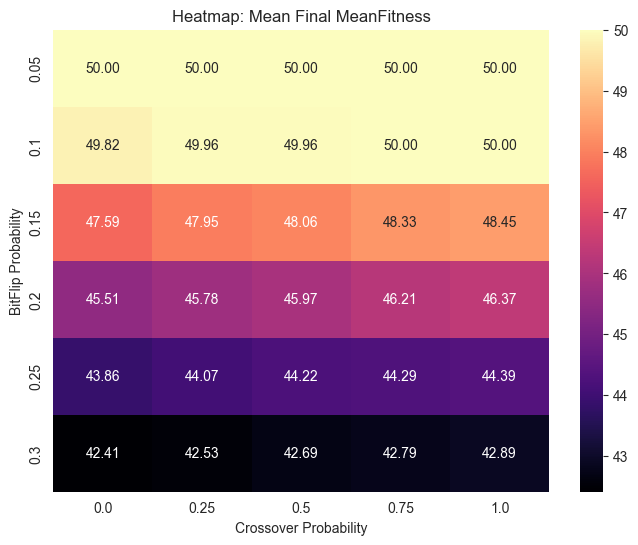

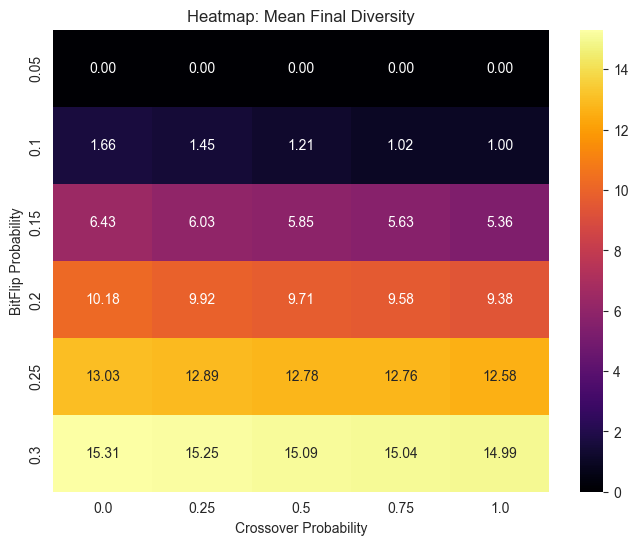

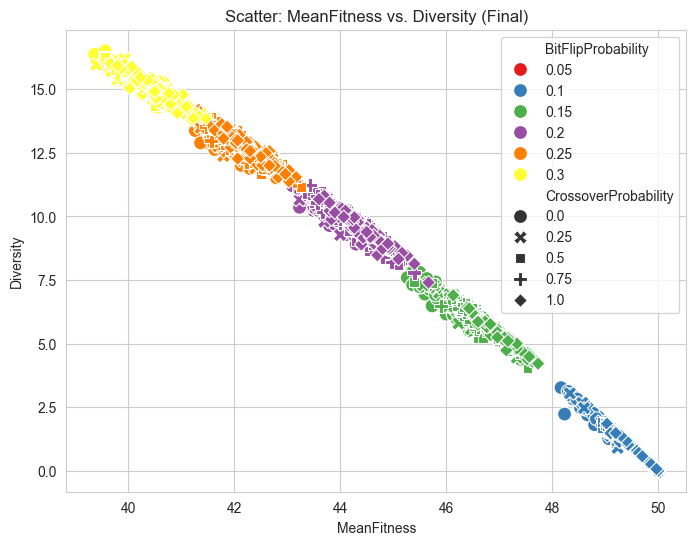

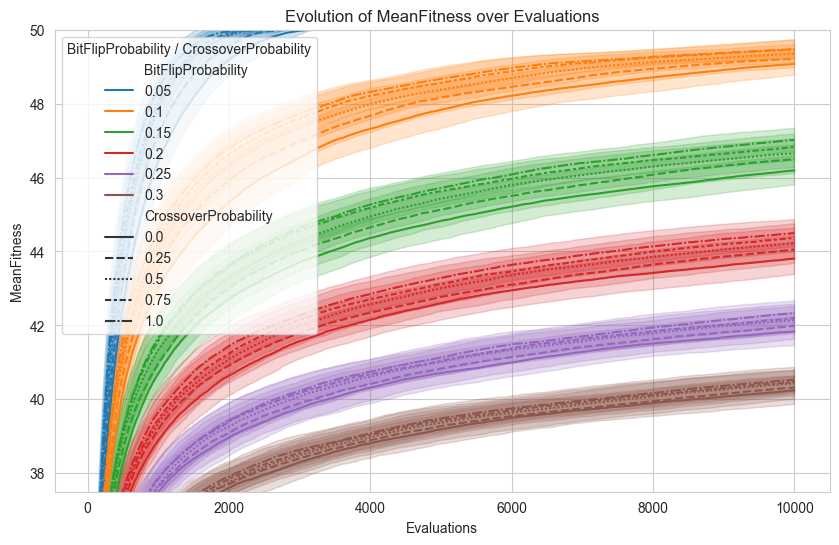

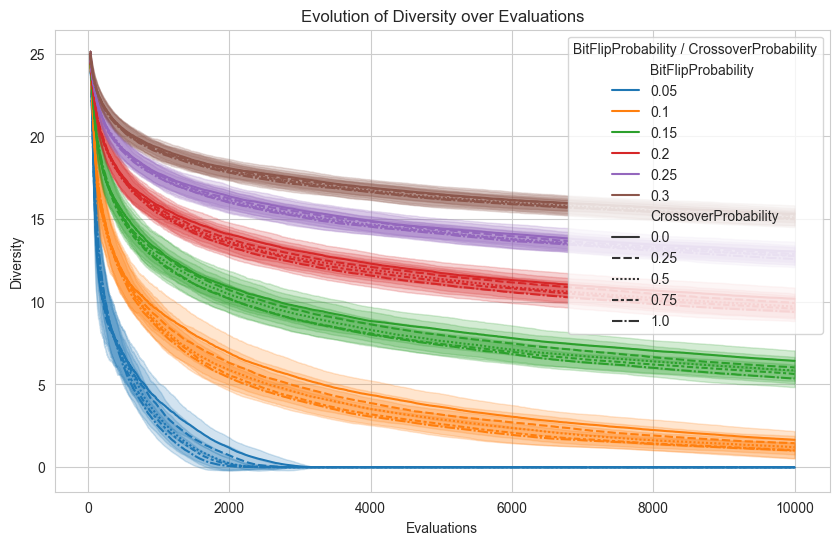

C:\Users\rafac\AppData\Local\Temp\ipykernel_10132\2718358213.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


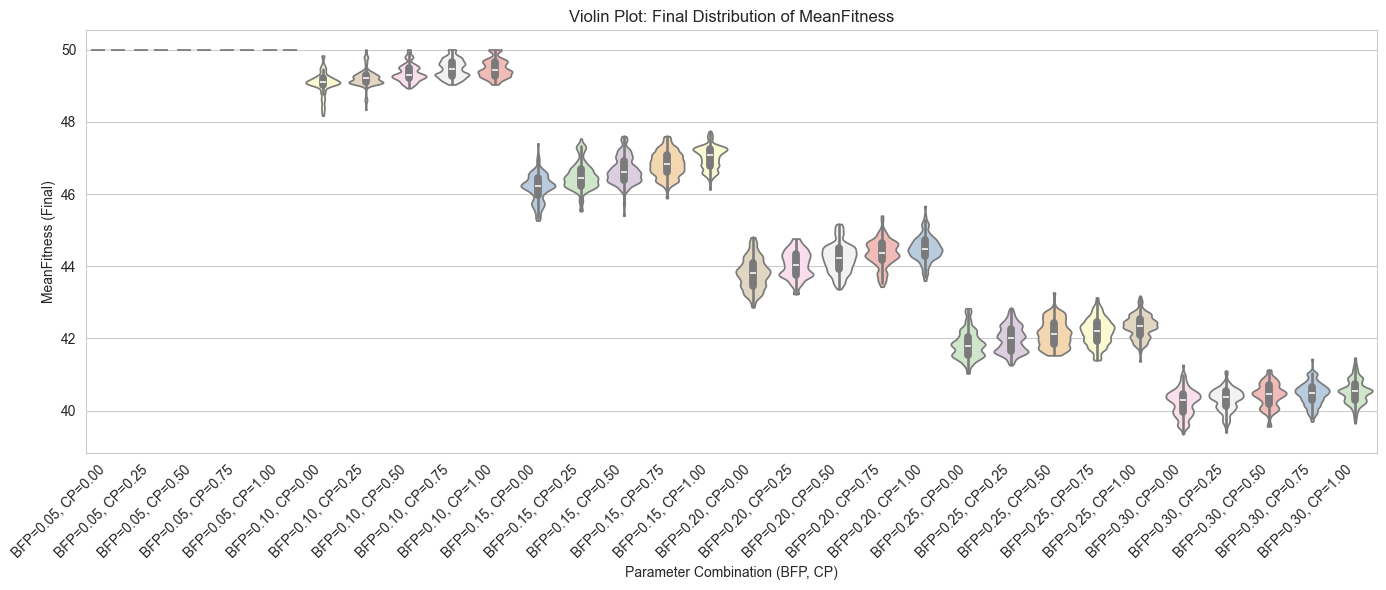

C:\Users\rafac\AppData\Local\Temp\ipykernel_10132\2718358213.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


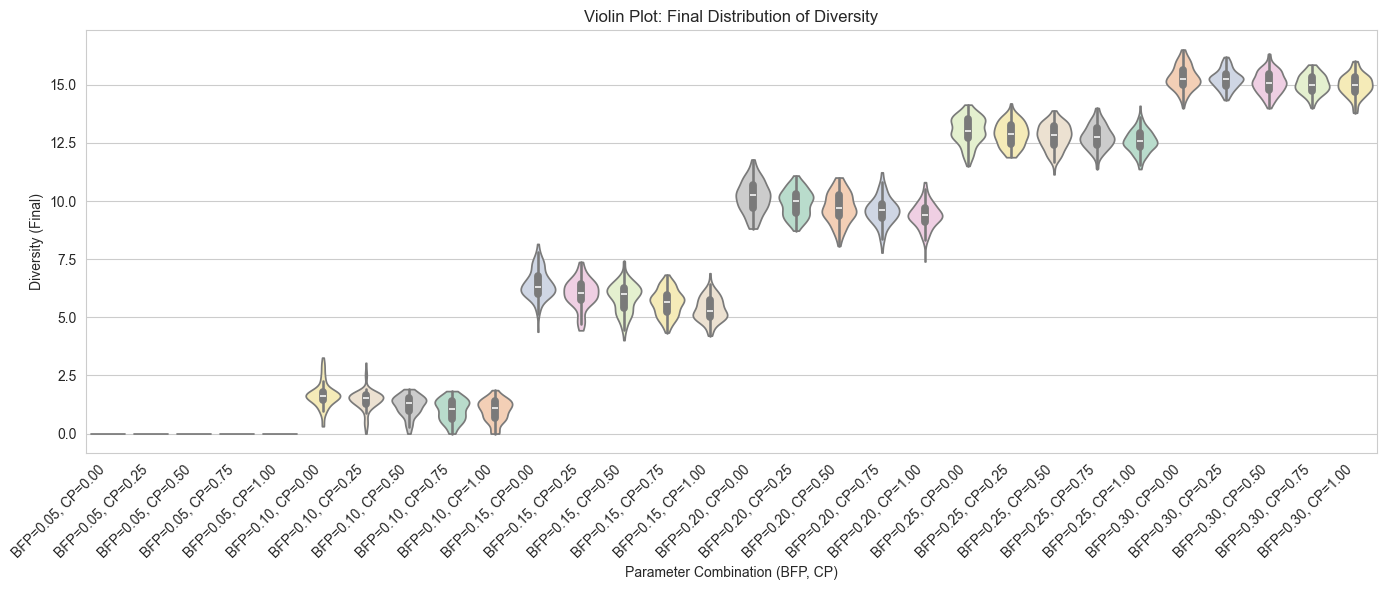

2025-02-16 23:37:36,064 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-16 23:37:36,069 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


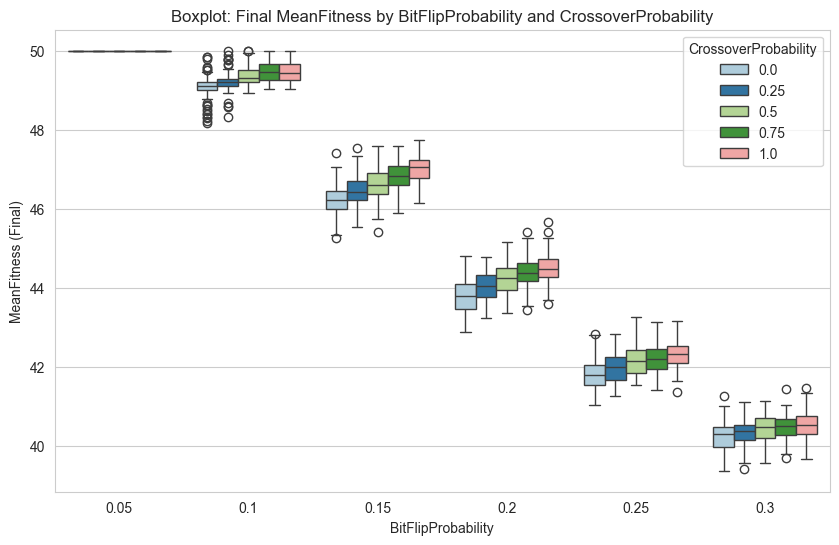

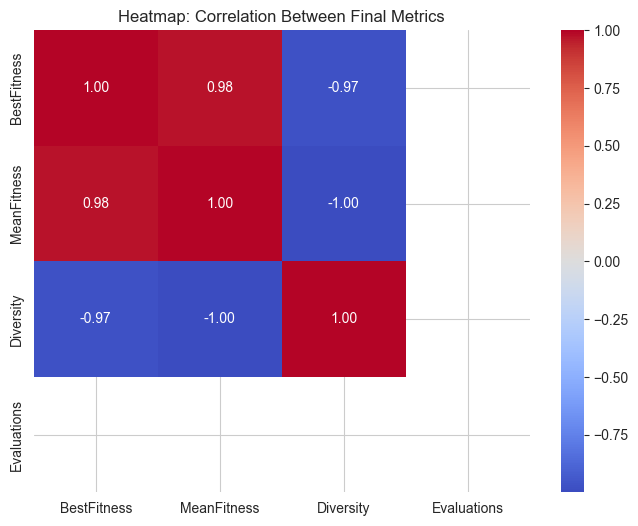

In [6]:
df = load_df(50, "false")
df = df[df["Evaluations"] <= 10000]
display(df)
tables = generate_tables(df)
print("Resumen de Fitness Final:")
display(tables["fitness_summary"])
print("\nResumen de Diversidad Final:")
display(tables["diversity_summary"])
print("\nResumen de Evaluaciones:")
display(tables["evaluations_summary"])
generate_plots(df)

2025-02-16 23:37:36,374 - INFO - Found 2970 CSV files in Data/ProS_50/Es_true
Processing files: 100%|██████████| 2970/2970 [00:08<00:00, 334.56it/s]
2025-02-16 23:37:46,288 - INFO - Combined DataFrame shape: (42656107, 10)


Evaluations  BestFitness  MeanFitness  Diversity  UniqueIndividuals  \
0                  31           34      25.7667    25.0138                 30   
1                  32           34      25.9667    25.0322                 30   
2                  33           34      26.2333    24.9678                 30   
3                  34           34      26.4333    24.9310                 30   
4                  35           34      26.6667    24.8230                 30   
...               ...          ...          ...        ...                ...   
42656102        19996           45      42.3000    12.8115                 30   
42656103        19997           45      42.3000    12.8115                 30   
42656104        19998           45      42.3667    12.7563                 30   
42656105        19999           45      42.3667    12.7563                 30   
42656106        20000           45      42.3667    12.7563                 30   

          PopulationSize  ProblemSize  BitFlipProbability  \
0                     30           50                0.05   
1                     30           50                0.05   
2                     30           50                0.05   
3                     30           50                0.05   
4                     30           50                0.05   
...                  ...          ...                 ...   
42656102              30           50                0.30   
42656103              30           50                0.30   
42656104              30           50                0.30   
42656105              30           50                0.30   
42656106              30           50                0.30   

          CrossoverProbability  RandomSeed  
0                          0.0          10  
1                          0.0          10  
2                          0.0          10  
3                          0.0          10  
4                          0.0          10  
...                        ...         ...  
42656102                   1.0          99  
42656103                   1.0          99  
42656104                   1.0          99  
42656105                   1.0          99  
42656106                   1.0          99  

[42656107 rows x 10 columns]

Fitness Summary:


BitFlipProbability  CrossoverProbability  MeanFinalFitness  \
0                 0.05                  0.00         48.587873   
1                 0.05                  0.25         48.501005   
2                 0.05                  0.50         48.343430   
3                 0.05                  0.75         48.285191   
4                 0.05                  1.00         48.159259   
5                 0.10                  0.00         48.465308   
6                 0.10                  0.25         48.284172   
7                 0.10                  0.50         48.392929   
8                 0.10                  0.75         48.145447   
9                 0.10                  1.00         48.209762   
10                0.15                  0.00         47.291923   
11                0.15                  0.25         47.444110   
12                0.15                  0.50         47.608410   
13                0.15                  0.75         47.743100   
14                0.15                  1.00         47.855896   
15                0.20                  0.00         44.883504   
16                0.20                  0.25         45.027271   
17                0.20                  0.50         45.226262   
18                0.20                  0.75         45.390913   
19                0.20                  1.00         45.551178   
20                0.25                  0.00         42.869359   
21                0.25                  0.25         43.009430   
22                0.25                  0.50         43.110434   
23                0.25                  0.75         43.255898   
24                0.25                  1.00         43.305723   
25                0.30                  0.00         41.241748   
26                0.30                  0.25         41.316165   
27                0.30                  0.50         41.411783   
28                0.30                  0.75         41.495625   
29                0.30                  1.00         41.503703   

    StdFinalFitness  MaxFinalFitness  MinFinalFitness  
0          0.383709          49.0333          47.3667  
1          0.455104          49.0333          46.1667  
2          0.486440          49.0333          46.7667  
3          0.499956          49.0333          46.5333  
4          0.662386          49.0333          45.8000  
5          0.505811          49.0333          46.5333  
6          0.523810          49.0333          46.2667  
7          0.423917          49.0333          47.1333  
8          0.738714          49.0333          44.6000  
9          0.602282          49.0333          46.4333  
10         0.319576          48.3000          46.4000  
11         0.304679          48.2667          46.5333  
12         0.350293          48.2333          46.2000  
13         0.369354          48.3667          46.4667  
14         0.396176          48.3667          46.3667  
15         0.401851          45.8667          44.0000  
16         0.351298          45.6000          44.2000  
17         0.332998          46.1000          44.4667  
18         0.328704          46.2000          44.6333  
19         0.276570          46.4000          44.9000  
20         0.361859          43.8333          42.1333  
21         0.376856          44.3667          42.2333  
22         0.343373          44.0000          42.3000  
23         0.322047          44.0667          42.5000  
24         0.306025          44.1333          42.4333  
25         0.343362          42.3333          40.5333  
26         0.350905          42.2333          40.4333  
27         0.308143          42.7000          40.6333  
28         0.304419          42.1667          40.5333  
29         0.271050          42.3667          40.8333


Diversity Summary:


BitFlipProbability  CrossoverProbability  MeanFinalDiversity  \
0                 0.05                  0.00            1.852824   
1                 0.05                  0.25            2.040360   
2                 0.05                  0.50            2.419597   
3                 0.05                  0.75            2.543249   
4                 0.05                  1.00            2.836289   
5                 0.10                  0.00            2.617206   
6                 0.10                  0.25            2.944338   
7                 0.10                  0.50            2.877671   
8                 0.10                  0.75            3.293305   
9                 0.10                  1.00            3.199516   
10                0.15                  0.00            4.767239   
11                0.15                  0.25            4.579145   
12                0.15                  0.50            4.347915   
13                0.15                  0.75            4.135354   
14                0.15                  1.00            3.983792   
15                0.20                  0.00            8.683940   
16                0.20                  0.25            8.564290   
17                0.20                  0.50            8.283614   
18                0.20                  0.75            8.058406   
19                0.20                  1.00            7.833301   
20                0.25                  0.00           11.752141   
21                0.25                  0.25           11.579754   
22                0.25                  0.50           11.527922   
23                0.25                  0.75           11.327207   
24                0.25                  1.00           11.266228   
25                0.30                  0.00           14.072582   
26                0.30                  0.25           13.986648   
27                0.30                  0.50           13.889958   
28                0.30                  0.75           13.802254   
29                0.30                  1.00           13.819945   

    StdFinalDiversity  MaxFinalDiversity  MinFinalDiversity  
0            0.642484             3.9057             0.5540  
1            0.716132             5.0966             0.4391  
2            0.809023             4.6805             0.6598  
3            0.802659             5.6000             0.6161  
4            0.968113             5.9632             0.5540  
5            0.803356             5.6322             1.4276  
6            0.830097             6.0414             1.6437  
7            0.695219             4.8644             1.5885  
8            1.158419             8.3678             1.7218  
9            0.993566             5.9425             1.5471  
10           0.525506             6.0782             2.8437  
11           0.507718             6.0598             3.2575  
12           0.589721             6.4460             3.1655  
13           0.627718             6.2253             3.1149  
14           0.672220             6.4598             3.0644  
15           0.654215            10.2299             7.0437  
16           0.558574             9.8253             7.6046  
17           0.528960             9.4529             7.0460  
18           0.529237             9.4506             6.8690  
19           0.437150             8.8460             6.5011  
20           0.552842            12.8460            10.3977  
21           0.546742            12.8276             9.8506  
22           0.522512            12.6207            10.1655  
23           0.481899            12.4529             9.9172  
24           0.468369            12.5816            10.0874  
25           0.501133            15.0483            12.7494  
26           0.483166            15.2759            12.6644  
27           0.419079            14.9540            12.1310  
28           0.402226            15.0345            12.8621  
29           0.373423            14


Evaluations Summary:


BitFlipProbability  CrossoverProbability  MeanEvaluations  StdEvaluations  \
0                 0.05                  0.00      1731.313131      333.419135   
1                 0.05                  0.25      1436.212121      287.353380   
2                 0.05                  0.50      1201.959596      270.188631   
3                 0.05                  0.75      1091.848485      235.080853   
4                 0.05                  1.00       999.404040      263.946072   
5                 0.10                  0.00      7910.454545     3101.093774   
6                 0.10                  0.25      5981.333333     2218.666229   
7                 0.10                  0.50      5762.161616     1681.653370   
8                 0.10                  0.75      4597.030303     1971.239015   
9                 0.10                  1.00      4399.949495     1730.517189   
10                0.15                  0.00     19966.414141      220.333792   
11                0.15                  0.25     19752.747475     1316.872930   
12                0.15                  0.50     19476.454545     1858.766166   
13                0.15                  0.75     18832.101010     2919.217604   
14                0.15                  1.00     18670.777778     3394.799458   
15                0.20                  0.00     20000.000000        0.000000   
16                0.20                  0.25     20000.000000        0.000000   
17                0.20                  0.50     20000.000000        0.000000   
18                0.20                  0.75     19959.606061      401.914622   
19                0.20                  1.00     20000.000000        0.000000   
20                0.25                  0.00     20000.000000        0.000000   
21                0.25                  0.25     20000.000000        0.000000   
22                0.25                  0.50     20000.000000        0.000000   
23                0.25                  0.75     20000.000000        0.000000   
24                0.25                  1.00     20000.000000        0.000000   
25                0.30                  0.00     20000.000000        0.000000   
26                0.30                  0.25     20000.000000        0.000000   
27                0.30                  0.50     20000.000000        0.000000   
28                0.30                  0.75     20000.000000        0.000000   
29                0.30                  1.00     20000.000000        0.000000   

    MinEvaluations  MaxEvaluations  
0             1134            2555  
1              640            2407  
2              604            2084  
3              588            2303  
4              505            2135  
5             2554           20000  
6             2521           13508  
7             2523           11342  
8              916           10355  
9             1602            9555  
10           18160           20000  
11           11652           20000  
12            9862           20000  
13            5757           20000  
14            3135           20000  
15           20000           20000  
16           20000           20000  
17           20000           20000  
18           16001           20000  
19           20000           20000  
20           20000           20000  
21           20000           20000  
22           20000           20000  
23           20000           20000  
24           20000           20000  
25           20000           20000  
26           20000           20000  
27           20000           20000  
28           20000           20000  
29           20000           20000

Resumen de Fitness Final:


BitFlipProbability  CrossoverProbability  MeanFinalFitness  \
0                 0.05                  0.00         48.587873   
1                 0.05                  0.25         48.501005   
2                 0.05                  0.50         48.343430   
3                 0.05                  0.75         48.285191   
4                 0.05                  1.00         48.159259   
5                 0.10                  0.00         48.465308   
6                 0.10                  0.25         48.284172   
7                 0.10                  0.50         48.392929   
8                 0.10                  0.75         48.145447   
9                 0.10                  1.00         48.209762   
10                0.15                  0.00         47.291923   
11                0.15                  0.25         47.444110   
12                0.15                  0.50         47.608410   
13                0.15                  0.75         47.743100   
14                0.15                  1.00         47.855896   
15                0.20                  0.00         44.883504   
16                0.20                  0.25         45.027271   
17                0.20                  0.50         45.226262   
18                0.20                  0.75         45.390913   
19                0.20                  1.00         45.551178   
20                0.25                  0.00         42.869359   
21                0.25                  0.25         43.009430   
22                0.25                  0.50         43.110434   
23                0.25                  0.75         43.255898   
24                0.25                  1.00         43.305723   
25                0.30                  0.00         41.241748   
26                0.30                  0.25         41.316165   
27                0.30                  0.50         41.411783   
28                0.30                  0.75         41.495625   
29                0.30                  1.00         41.503703   

    StdFinalFitness  MaxFinalFitness  MinFinalFitness  
0          0.383709          49.0333          47.3667  
1          0.455104          49.0333          46.1667  
2          0.486440          49.0333          46.7667  
3          0.499956          49.0333          46.5333  
4          0.662386          49.0333          45.8000  
5          0.505811          49.0333          46.5333  
6          0.523810          49.0333          46.2667  
7          0.423917          49.0333          47.1333  
8          0.738714          49.0333          44.6000  
9          0.602282          49.0333          46.4333  
10         0.319576          48.3000          46.4000  
11         0.304679          48.2667          46.5333  
12         0.350293          48.2333          46.2000  
13         0.369354          48.3667          46.4667  
14         0.396176          48.3667          46.3667  
15         0.401851          45.8667          44.0000  
16         0.351298          45.6000          44.2000  
17         0.332998          46.1000          44.4667  
18         0.328704          46.2000          44.6333  
19         0.276570          46.4000          44.9000  
20         0.361859          43.8333          42.1333  
21         0.376856          44.3667          42.2333  
22         0.343373          44.0000          42.3000  
23         0.322047          44.0667          42.5000  
24         0.306025          44.1333          42.4333  
25         0.343362          42.3333          40.5333  
26         0.350905          42.2333          40.4333  
27         0.308143          42.7000          40.6333  
28         0.304419          42.1667          40.5333  
29         0.271050          42.3667          40.8333


Resumen de Diversidad Final:


BitFlipProbability  CrossoverProbability  MeanFinalDiversity  \
0                 0.05                  0.00            1.852824   
1                 0.05                  0.25            2.040360   
2                 0.05                  0.50            2.419597   
3                 0.05                  0.75            2.543249   
4                 0.05                  1.00            2.836289   
5                 0.10                  0.00            2.617206   
6                 0.10                  0.25            2.944338   
7                 0.10                  0.50            2.877671   
8                 0.10                  0.75            3.293305   
9                 0.10                  1.00            3.199516   
10                0.15                  0.00            4.767239   
11                0.15                  0.25            4.579145   
12                0.15                  0.50            4.347915   
13                0.15                  0.75            4.135354   
14                0.15                  1.00            3.983792   
15                0.20                  0.00            8.683940   
16                0.20                  0.25            8.564290   
17                0.20                  0.50            8.283614   
18                0.20                  0.75            8.058406   
19                0.20                  1.00            7.833301   
20                0.25                  0.00           11.752141   
21                0.25                  0.25           11.579754   
22                0.25                  0.50           11.527922   
23                0.25                  0.75           11.327207   
24                0.25                  1.00           11.266228   
25                0.30                  0.00           14.072582   
26                0.30                  0.25           13.986648   
27                0.30                  0.50           13.889958   
28                0.30                  0.75           13.802254   
29                0.30                  1.00           13.819945   

    StdFinalDiversity  MaxFinalDiversity  MinFinalDiversity  
0            0.642484             3.9057             0.5540  
1            0.716132             5.0966             0.4391  
2            0.809023             4.6805             0.6598  
3            0.802659             5.6000             0.6161  
4            0.968113             5.9632             0.5540  
5            0.803356             5.6322             1.4276  
6            0.830097             6.0414             1.6437  
7            0.695219             4.8644             1.5885  
8            1.158419             8.3678             1.7218  
9            0.993566             5.9425             1.5471  
10           0.525506             6.0782             2.8437  
11           0.507718             6.0598             3.2575  
12           0.589721             6.4460             3.1655  
13           0.627718             6.2253             3.1149  
14           0.672220             6.4598             3.0644  
15           0.654215            10.2299             7.0437  
16           0.558574             9.8253             7.6046  
17           0.528960             9.4529             7.0460  
18           0.529237             9.4506             6.8690  
19           0.437150             8.8460             6.5011  
20           0.552842            12.8460            10.3977  
21           0.546742            12.8276             9.8506  
22           0.522512            12.6207            10.1655  
23           0.481899            12.4529             9.9172  
24           0.468369            12.5816            10.0874  
25           0.501133            15.0483            12.7494  
26           0.483166            15.2759            12.6644  
27           0.419079            14.9540            12.1310  
28           0.402226            15.0345            12.8621  
29           0.373423            14


Resumen de Evaluaciones:


BitFlipProbability  CrossoverProbability  MeanEvaluations  StdEvaluations  \
0                 0.05                  0.00      1731.313131      333.419135   
1                 0.05                  0.25      1436.212121      287.353380   
2                 0.05                  0.50      1201.959596      270.188631   
3                 0.05                  0.75      1091.848485      235.080853   
4                 0.05                  1.00       999.404040      263.946072   
5                 0.10                  0.00      7910.454545     3101.093774   
6                 0.10                  0.25      5981.333333     2218.666229   
7                 0.10                  0.50      5762.161616     1681.653370   
8                 0.10                  0.75      4597.030303     1971.239015   
9                 0.10                  1.00      4399.949495     1730.517189   
10                0.15                  0.00     19966.414141      220.333792   
11                0.15                  0.25     19752.747475     1316.872930   
12                0.15                  0.50     19476.454545     1858.766166   
13                0.15                  0.75     18832.101010     2919.217604   
14                0.15                  1.00     18670.777778     3394.799458   
15                0.20                  0.00     20000.000000        0.000000   
16                0.20                  0.25     20000.000000        0.000000   
17                0.20                  0.50     20000.000000        0.000000   
18                0.20                  0.75     19959.606061      401.914622   
19                0.20                  1.00     20000.000000        0.000000   
20                0.25                  0.00     20000.000000        0.000000   
21                0.25                  0.25     20000.000000        0.000000   
22                0.25                  0.50     20000.000000        0.000000   
23                0.25                  0.75     20000.000000        0.000000   
24                0.25                  1.00     20000.000000        0.000000   
25                0.30                  0.00     20000.000000        0.000000   
26                0.30                  0.25     20000.000000        0.000000   
27                0.30                  0.50     20000.000000        0.000000   
28                0.30                  0.75     20000.000000        0.000000   
29                0.30                  1.00     20000.000000        0.000000   

    MinEvaluations  MaxEvaluations  
0             1134            2555  
1              640            2407  
2              604            2084  
3              588            2303  
4              505            2135  
5             2554           20000  
6             2521           13508  
7             2523           11342  
8              916           10355  
9             1602            9555  
10           18160           20000  
11           11652           20000  
12            9862           20000  
13            5757           20000  
14            3135           20000  
15           20000           20000  
16           20000           20000  
17           20000           20000  
18           16001           20000  
19           20000           20000  
20           20000           20000  
21           20000           20000  
22           20000           20000  
23           20000           20000  
24           20000           20000  
25           20000           20000  
26           20000           20000  
27           20000           20000  
28           20000           20000  
29           20000           20000

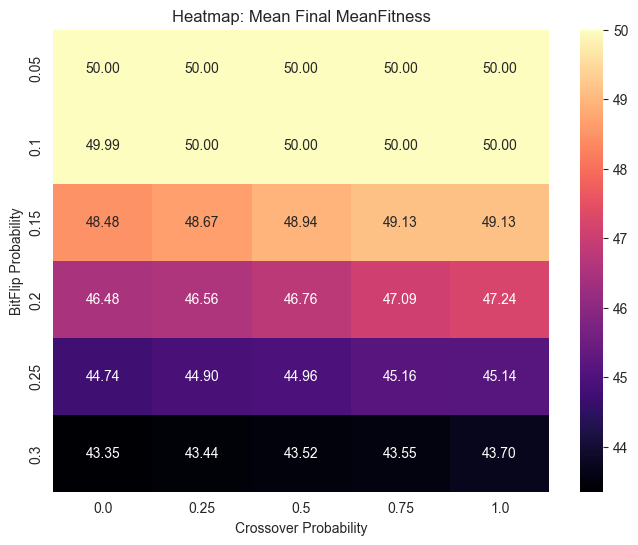

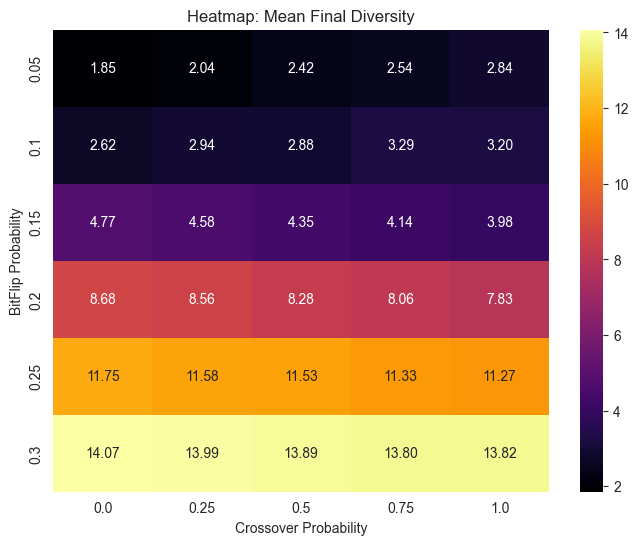

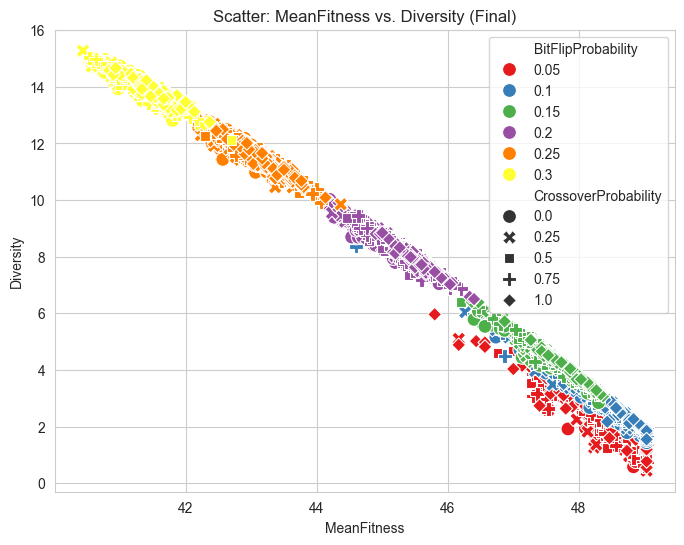

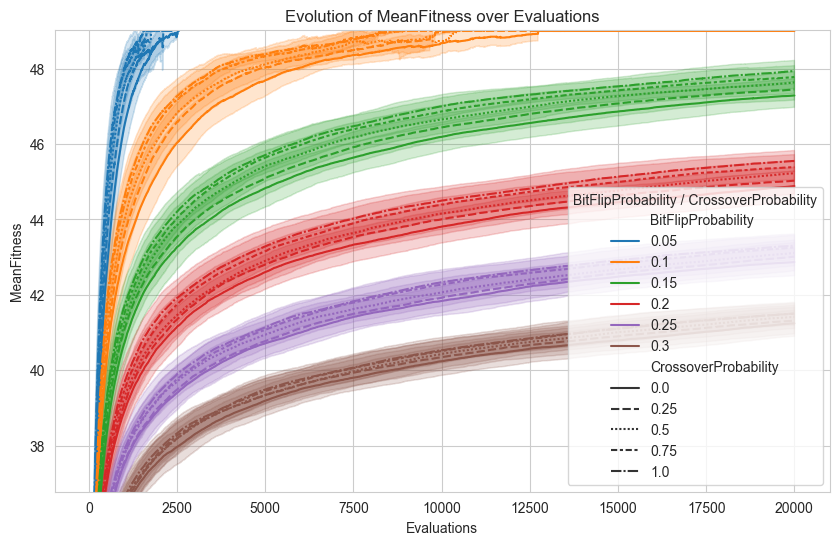

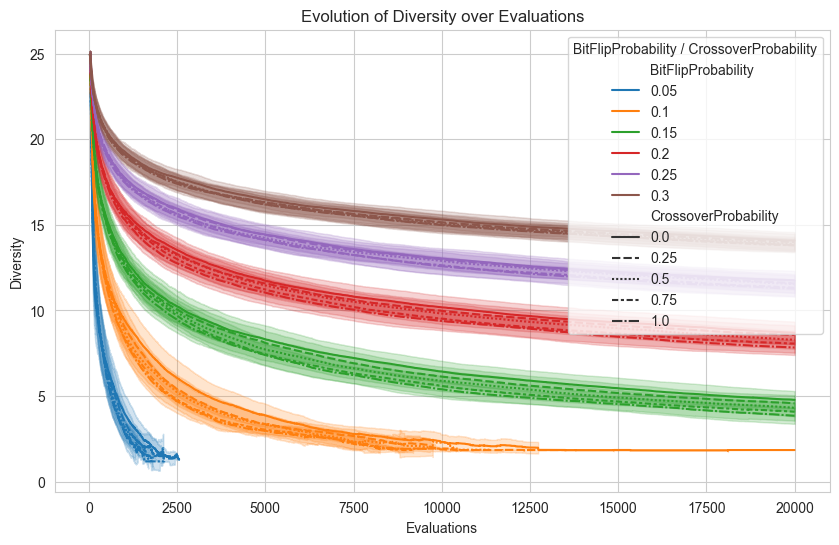

C:\Users\rafac\AppData\Local\Temp\ipykernel_10132\2718358213.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


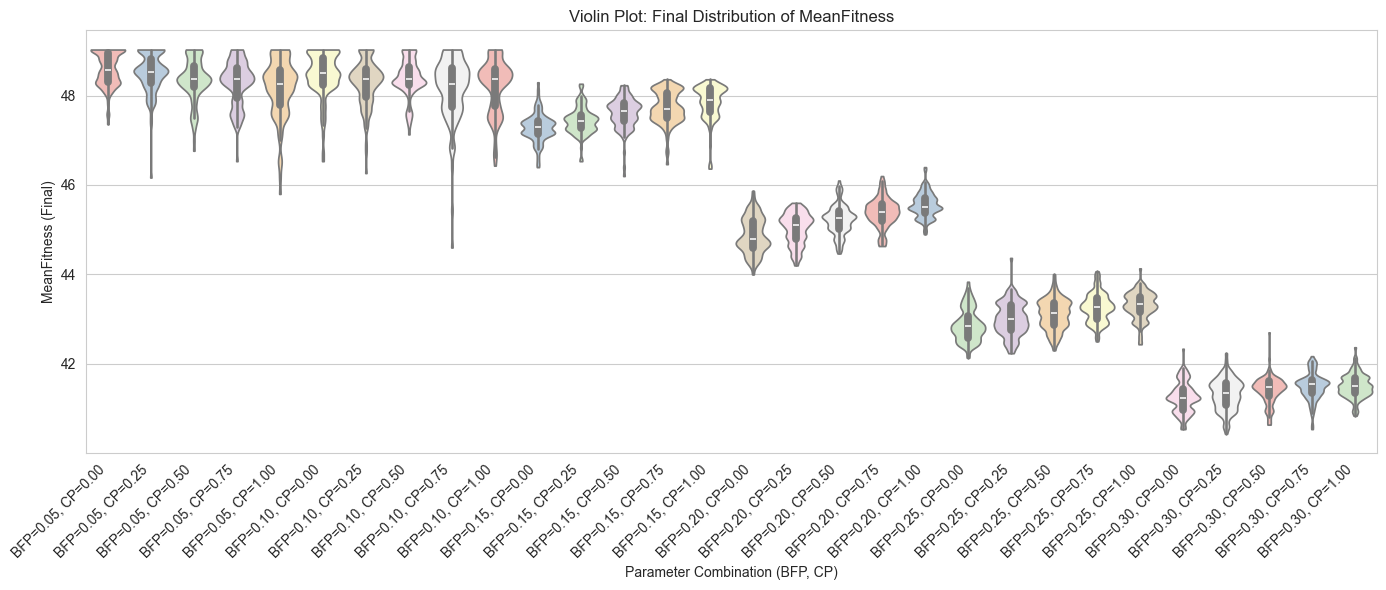

C:\Users\rafac\AppData\Local\Temp\ipykernel_10132\2718358213.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


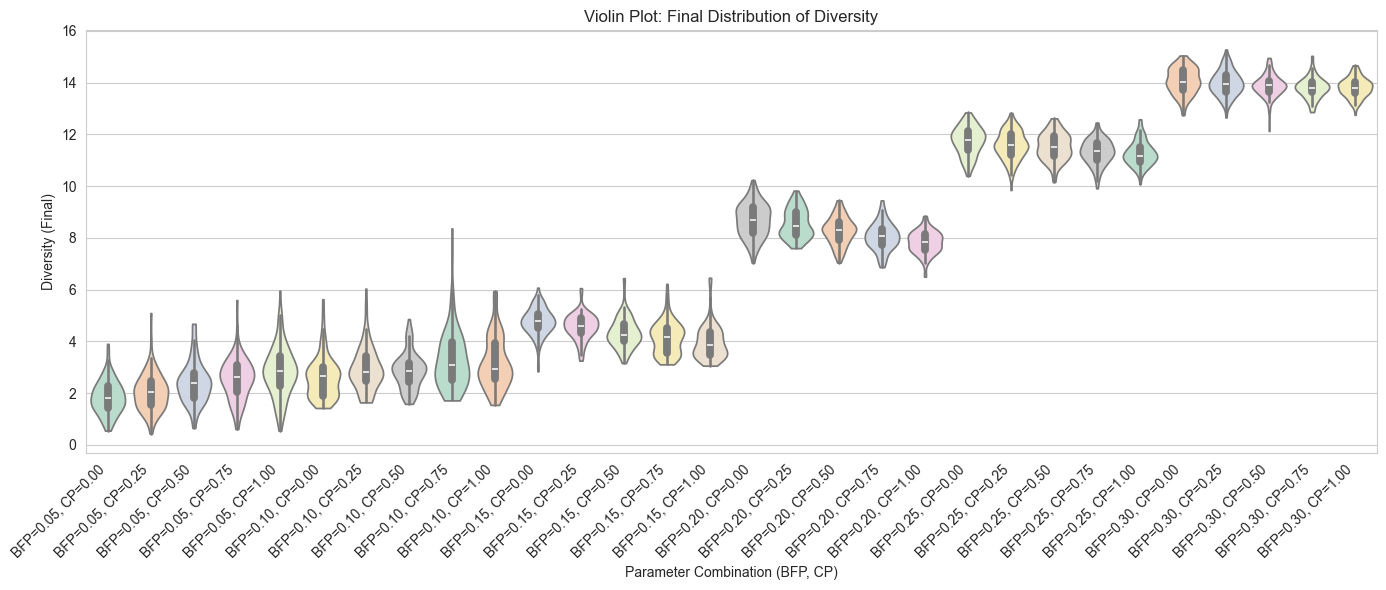

2025-02-16 23:41:22,114 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-16 23:41:22,119 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


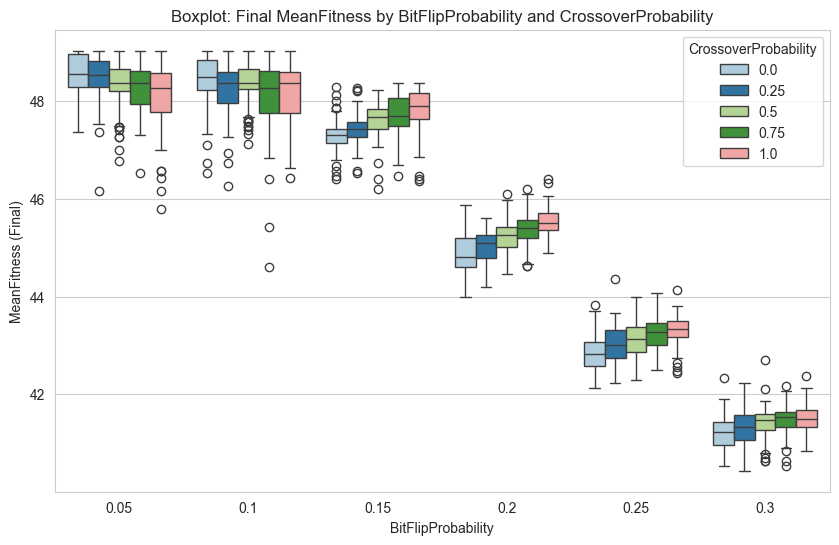

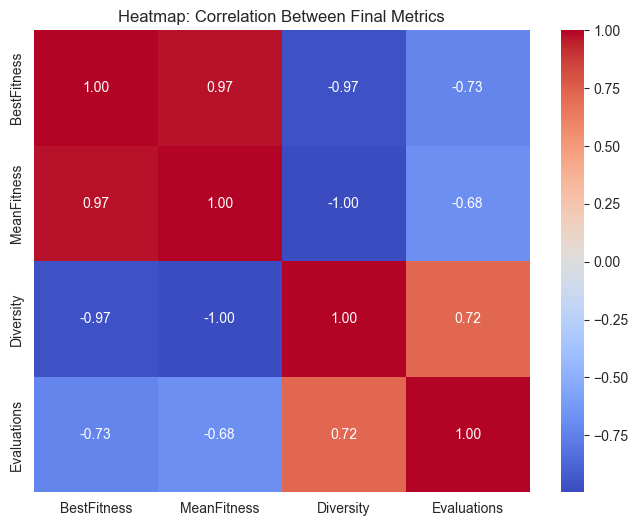

In [7]:
df = load_df(50, "true")
# df = df[df["Evaluations"] <= 10000]
display(df)
tables = generate_tables(df)
print("Resumen de Fitness Final:")
display(tables["fitness_summary"])
print("\nResumen de Diversidad Final:")
display(tables["diversity_summary"])
print("\nResumen de Evaluaciones:")
display(tables["evaluations_summary"])
generate_plots(df)